In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from delase import DeLASE
from delase.metrics import mase
import h5py
from hydra import initialize, compose
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import powerlaw
from scipy.stats import poisson
import sys
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple, Any

from UniversalUnconsciousness.data_utils import get_all_session_loc_roc_info, get_grid_params_to_use, find_noisy_data
from UniversalUnconsciousness.hdf5_utils import *
from UniversalUnconsciousness.iaaft import surrogates
from UniversalUnconsciousness.plot_utils import *

load_font()
plt.style.use('UniversalUnconsciousness.sci_style')

In [3]:
data_save_dir = '/om/weka/millerlab/eisenaj/UniversalUnconsciousness'
assert os.path.exists(data_save_dir)
avalanche_data_dir = os.path.join(data_save_dir, 'avalanche_analysis')
os.makedirs(avalanche_data_dir, exist_ok=True)

# Code for avalanche analysis v2

In [4]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list

In [7]:
def get_session_list(cfg, data_class, agent, use_individual_areas=True):
    if 'propofol' in cfg.params.data_class:
        session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class)) if f.endswith('.mat')]
        # areas = ['all'] if not use_indvidiual_areas else ['vlPFC', 'FEF', '7b', 'CPB']
        areas = ['all'] if not use_individual_areas else ['vlPFC']
        data_dir = os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class)
    else:
        session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat')) if f.endswith('.mat')]
        data_dir = os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat')
        session_list = [session for session in session_list if session not in ['PEDRI_Ketamine_20220203']]
        session_list = [session for session in session_list if agent.lower()[:3] in session.lower()]
        # areas = ['all'] if not use_individual_areas else ['vlPFC-L', 'vlPFC-R', 'dlPFC-L', 'dlPFC-R']
        areas = ['all'] if not use_individual_areas else ['vlPFC-L']

        # filter high dose sessions only
        high_dose_session_list = []
        for session in session_list:
            with h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', session + '.mat'), 'r') as session_file:
                dose = session_file['sessionInfo']['dose'][0, 0]
                if dose > 9:
                    high_dose_session_list.append(session)
        session_list = high_dose_session_list
    
    session_lists, locs, rocs, ropaps = get_all_session_loc_roc_info(cfg, session_list, verbose=False)

    return session_lists, areas, data_dir

def get_neuron_spike_times(session_file):
    neuron_spike_times = []
    for i in range(session_file['spikeTimes'].shape[0]):
        neuron_spikes_ref = session_file['spikeTimes'][i, 0]
        neuron_spikes = session_file[neuron_spikes_ref][:, 0]
        neuron_spike_times.append(neuron_spikes)
    return neuron_spike_times
    
def get_spike_raster(neuron_spike_times, bin_size, jitter=False):
    min_spike_time = np.min(np.array([np.min(neuron_spike_times[i]) if len(neuron_spike_times[i]) > 0 else np.inf for i in range(len(neuron_spike_times))]))
    max_spike_time = np.max(np.array([np.max(neuron_spike_times[i]) if len(neuron_spike_times[i]) > 0 else -np.inf for i in range(len(neuron_spike_times))]))
    time_bins = np.arange(min_spike_time, max_spike_time, bin_size)
    spike_raster = np.zeros((len(time_bins), len(neuron_spike_times)))

    for i in range(len(neuron_spike_times)):
        neuron_spikes = neuron_spike_times[i]
        if jitter:
            if len(neuron_spikes) < 2:
                continue
            mean_ISI = np.mean(np.diff(neuron_spikes))
            if np.isnan(mean_ISI):
                continue
            jitter_amount = np.random.uniform(-mean_ISI, mean_ISI, len(neuron_spikes))
            neuron_spikes += jitter_amount
        bin_indices = np.digitize(neuron_spikes, time_bins)
        for ind in bin_indices:
            spike_raster[ind - 1, i] += 1
    
    return spike_raster, time_bins

def find_optimal_threshold(spike_presences, spike_presences_jittered, verbose=False):
    # np.histogram is >= left edge, < right edge
    bins = np.arange(0, np.max([spike_presences.max(), spike_presences_jittered.max()]), 1)
    h1, b1 = np.histogram(spike_presences, bins=bins)
    h2, b2 = np.histogram(spike_presences_jittered, bins=bins)

    if verbose:
        plt.hist(spike_presences, bins=bins)
        plt.hist(spike_presences_jittered, bins=bins, label='jittered')
        plt.yscale('log')
        plt.legend()
        plt.show()

    poisson_p_values = np.zeros(len(h1) - 1)
    # skip the first bin because it's 0
    for i in range(1, len(h1)):
        poisson_p_values[i - 1] = poisson.sf(h1[i] - 1, mu=h2[i])

    # find the first bin where the p-values are less than 0.05
    # for 3 consecutive bins
    for i in range(len(poisson_p_values) - 2):
        if poisson_p_values[i] < 0.05 and poisson_p_values[i + 1] < 0.05 and poisson_p_values[i + 2] < 0.05:
            chosen_bin = i
            break

    # add 1 to the chosen bin because
    # we dropped the first bin
    threshold = chosen_bin + 1
    if verbose:
        print(f"Threshold: {threshold}")
    return threshold

def compute_avalanche_stats(spike_presences, spike_tots, threshold):
    avalanche_presences = (spike_presences >= threshold)
    avalanche_sizes = []
    avalanche_sizes_units = []
    avalanche_durations = []
    is_avalanche = False
    current_size = 0 # in units of total spikes
    current_size_units = 0 # in units of number of units active
    current_duration = 0 # in units of bins
    for i in range(len(avalanche_presences)):
        if avalanche_presences[i]:
            is_avalanche = True
            current_size += spike_tots[i]
            current_size_units += spike_presences[i]
            current_duration += 1
        elif is_avalanche:
            avalanche_sizes.append(current_size)
            avalanche_sizes_units.append(current_size_units)
            avalanche_durations.append(current_duration)
            is_avalanche = False
            current_size = 0
            current_size_units = 0
            current_duration = 0

    avalanche_sizes = np.array(avalanche_sizes)
    avalanche_sizes_units = np.array(avalanche_sizes_units)
    avalanche_durations = np.array(avalanche_durations)

    return avalanche_sizes, avalanche_sizes_units, avalanche_durations

def select_best_distribution(data, xmin_range=None, verbose=False):
    """
    Fits multiple distributions to the data, calculates their BIC scores,
    and returns a ranked list of the best models.

    Args:
        data (np.ndarray): The array of avalanche sizes.
        xmin_range (tuple, optional): A tuple (min_val, max_val) to constrain
                                     the xmin search, preventing unreasonable fits.
                                     If None, the search is unconstrained.

    Returns:
        list: A list of dictionaries, sorted by the best (lowest) BIC score.
    """
    if xmin_range:
        if verbose:
            print(f"Constraining xmin search to the range {xmin_range}")
    
    # --- Step 1: Fit the data using the powerlaw package ---
    # We initialize the fit with the search range for xmin.
    fit = powerlaw.Fit(data, xmin=xmin_range, verbose=verbose)
    if verbose:
        print(f"\nOptimal xmin for Power Law found at: {fit.power_law.xmin:.2f}")
        print(f"Number of data points in tail (n_tail): {fit.n_tail}")

    # --- Step 2: Define the candidate distributions and their complexity (k) ---
    # Number of parameters for each distribution
    dist_params = {
        'power_law': 1,
        'exponential': 1,
        'lognormal': 2,
        'truncated_power_law': 2,
        'stretched_exponential': 2
    }
    
    results = []

    # --- Step 3: Loop through, calculate BIC for each, and store results ---
    if verbose:
        print("\nCalculating AIC/BIC for all candidate distributions...")
    for dist_name, k in dist_params.items():
        # The Fit object has already fitted each distribution
        dist_fit = getattr(fit, dist_name)

        # Get the log-likelihood of the fit
        # log_likelihood = dist_fit.loglikelihood
        log_likelihood = sum(dist_fit.loglikelihoods(fit.data))
        
        # Get the number of data points in the tail
        n = fit.n_tail

        # Calculate BIC and AIC
        bic = k * np.log(n) - 2 * log_likelihood
        aic = 2 * k - 2 * log_likelihood
        
        # Store results, including key parameters for interpretation
        params = {}
        if hasattr(dist_fit, 'alpha'): params['alpha'] = dist_fit.alpha
        if hasattr(dist_fit, 'Lambda'): params['lambda'] = dist_fit.Lambda
        if hasattr(dist_fit, 'mu'): params['mu'] = dist_fit.mu
        if hasattr(dist_fit, 'sigma'): params['sigma'] = dist_fit.sigma
        if hasattr(dist_fit, 'beta'): params['beta'] = dist_fit.beta

        results.append({
            'name': dist_name,
            'AIC': aic,
            'BIC': bic,
            'log_likelihood': log_likelihood,
            'k': k,
            'parameters': params
        })

    # --- Step 4: Sort results by AIC score (lowest is best) ---
    results.sort(key=lambda x: x['AIC'])
    
    return results, fit

def analyze_avalanches(cfg, anesthetic_agent_list, use_individiual_areas=True, bin_sizes: List[float]=[0.008]):
    if bin_sizes is None:
        bin_sizes = []

    avalanche_analysis_data: Dict[str, Any] = {}

    # num sessions
    num_evals = 0
    for data_class, agent in anesthetic_agent_list:
        # if agent != 'ketamine':
        #     continue
        session_lists, areas, data_dir = get_session_list(cfg, data_class, agent, use_individiual_areas)
        for area in areas:
            for monkey in session_lists.keys():
                num_evals += 1

    iterator = tqdm(total=num_evals)
    for data_class, agent in anesthetic_agent_list:
        # if agent != 'ketamine':
        #     continue

        avalanche_analysis_data[(data_class, agent)] = {}

        cfg.params.grid_set = 'grid_set6'
        cfg.params.data_class = data_class

        session_lists, areas, data_dir = get_session_list(cfg, data_class, agent, use_individiual_areas=use_individiual_areas)
        for monkey in session_lists.keys():

            avalanche_analysis_data[(data_class, agent)][monkey] = {}
            for area in areas:
                avalanche_analysis_data[(data_class, agent)][monkey][area] = {}
                avalanche_analysis_data[(data_class, agent)][monkey][area]['avalanche_statistics'] = {}
                avalanche_analysis_data[(data_class, agent)][monkey][area]['avalanche_statistics']['sizes'] = {'Awake': [], 'Anesthesia': []}
                avalanche_analysis_data[(data_class, agent)][monkey][area]['avalanche_statistics']['sizes_units'] = {'Awake': [], 'Anesthesia': []}
                avalanche_analysis_data[(data_class, agent)][monkey][area]['avalanche_statistics']['durations'] = {'Awake': [], 'Anesthesia': []}

            for session in tqdm(session_lists[monkey]['high']):
                session_file_path = os.path.join(data_dir, f"{session}.mat")
                with h5py.File(session_file_path, 'r') as session_file:
                    section_info, section_info_extended, section_colors, infusion_start = get_section_info(
                        session, cfg.params.all_data_dir, cfg.params.data_class, section_info_type='plot'
                    )
                    unit_areas = convert_h5_string_array(session_file, session_file['unitInfo']['area'][0])
                    if cfg.params.data_class == 'anesthesiaLvrOdd':
                        hemispheres = convert_h5_string_array(session_file, session_file['unitInfo']['hemisphere'])
                        hemispheres = [h[0].capitalize() for h in hemispheres]
                        unit_areas = np.array([f"{a}-{h}" for a, h in zip(unit_areas, hemispheres)])

                    neuron_spike_times = get_neuron_spike_times(session_file)
                    for area in areas:
                        # area_spike_raster = spike_raster[:, unit_areas == area]
                        area_neuron_spike_times = [neuron_spike_times[ind] for ind in np.where(unit_areas == area)[0]]
                        
                        ref_section = 'Awake'
                        ref_section_start, ref_section_end = section_info[np.where([info[0] == ref_section for info in section_info])[0][0]][1]
                        ref_section_start = ref_section_start * 60 + infusion_start
                        ref_section_end = ref_section_end * 60 + infusion_start

                        ref_spike_times = [area_neuron_spike_times[ind][(area_neuron_spike_times[ind] >= ref_section_start) & (area_neuron_spike_times[ind] < ref_section_end)] for ind in range(len(area_neuron_spike_times))]
                        sorted_spike_times = np.sort(np.hstack(ref_spike_times))
                        mean_ISI = np.mean(np.diff(sorted_spike_times))
                        # print(f"Mean ISI: {mean_ISI}")
                        bin_size = mean_ISI
                        avalanche_analysis_data[(data_class, agent)][monkey][area]['bin_size'] = bin_size

                        for section in ['Awake', 'Anesthesia']:
                            # print(f"MONKEY: {monkey}, AREA: {area}, SECTION: {section}")
                            section_start, section_end = section_info[np.where([info[0] == section for info in section_info])[0][0]][1]
                            section_start = section_start * 60 + infusion_start
                            section_end = section_end * 60 + infusion_start
                            area_section_neuron_spike_times = [neuron_spike_times[ind][(neuron_spike_times[ind] >= section_start) & (neuron_spike_times[ind] < section_end)] for ind in range(len(neuron_spike_times))]
                            area_section_spike_raster, time_bins = get_spike_raster(area_section_neuron_spike_times, bin_size)
                            area_section_spike_raster_jittered, time_bins_jittered = get_spike_raster(area_section_neuron_spike_times, bin_size, jitter=True)
                            
                            spike_tots = area_section_spike_raster.sum(axis=-1)
                            spike_presences = (area_section_spike_raster > 0).sum(axis=-1)

                            # spike_tots_jittered = area_section_spike_raster_jittered.sum(axis=-1)
                            # spike_presences_jittered = (area_section_spike_raster_jittered > 0).sum(axis=-1)

                            # threshold = find_optimal_threshold(spike_presences, spike_presences_jittered, verbose=False)

                            threshold = 2

                            avalanche_sizes, avalanche_sizes_units, avalanche_durations = compute_avalanche_stats(spike_presences, spike_tots, threshold)
                            avalanche_analysis_data[(data_class, agent)][monkey][area]['avalanche_statistics']['sizes'][section].extend(avalanche_sizes)
                            avalanche_analysis_data[(data_class, agent)][monkey][area]['avalanche_statistics']['sizes_units'][section].extend(avalanche_sizes_units)
                            avalanche_analysis_data[(data_class, agent)][monkey][area]['avalanche_statistics']['durations'][section].extend(avalanche_durations)

            for area in areas:
                avalanche_analysis_data[(data_class, agent)][monkey][area]['distribution_fits'] = {}
                for section in ['Awake', 'Anesthesia']:
                    sizes = np.array(avalanche_analysis_data[(data_class, agent)][monkey][area]['avalanche_statistics']['sizes'][section])
                    results, fit = select_best_distribution(sizes)
                    avalanche_analysis_data[(data_class, agent)][monkey][area]['distribution_fits'][section] = {'results': results, 'fit': fit}
                iterator.update(1)
    iterator.close()
    return avalanche_analysis_data

In [6]:
avalanche_analysis_data = analyze_avalanches(cfg, anesthetic_agent_list, use_individiual_areas=True)
# unit_areas, area, area_neuron_spike_times, ref_section_start, ref_section_end = analyze_avalanches(cfg, anesthetic_agent_list, use_individiual_areas=True)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/om2/user/eisenaj/miniforge3/envs/universal-unconsciousness/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


  0%|          | 0/11 [00:00<?, ?it/s]

'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


NameError: name 'use_individual_areas' is not defined

In [55]:
data_class, agent = ('propofolPuffTone', 'propofol')
monkey = 'Mary'
area = 'vlPFC'

In [60]:
num_plots = 24
monkey_name_map = {
    'Mary': 'NHP 1',
    'MrJones': 'NHP 2',
    'SPOCK': 'NHP 3',
    'PEDRI': 'NHP 4',
}

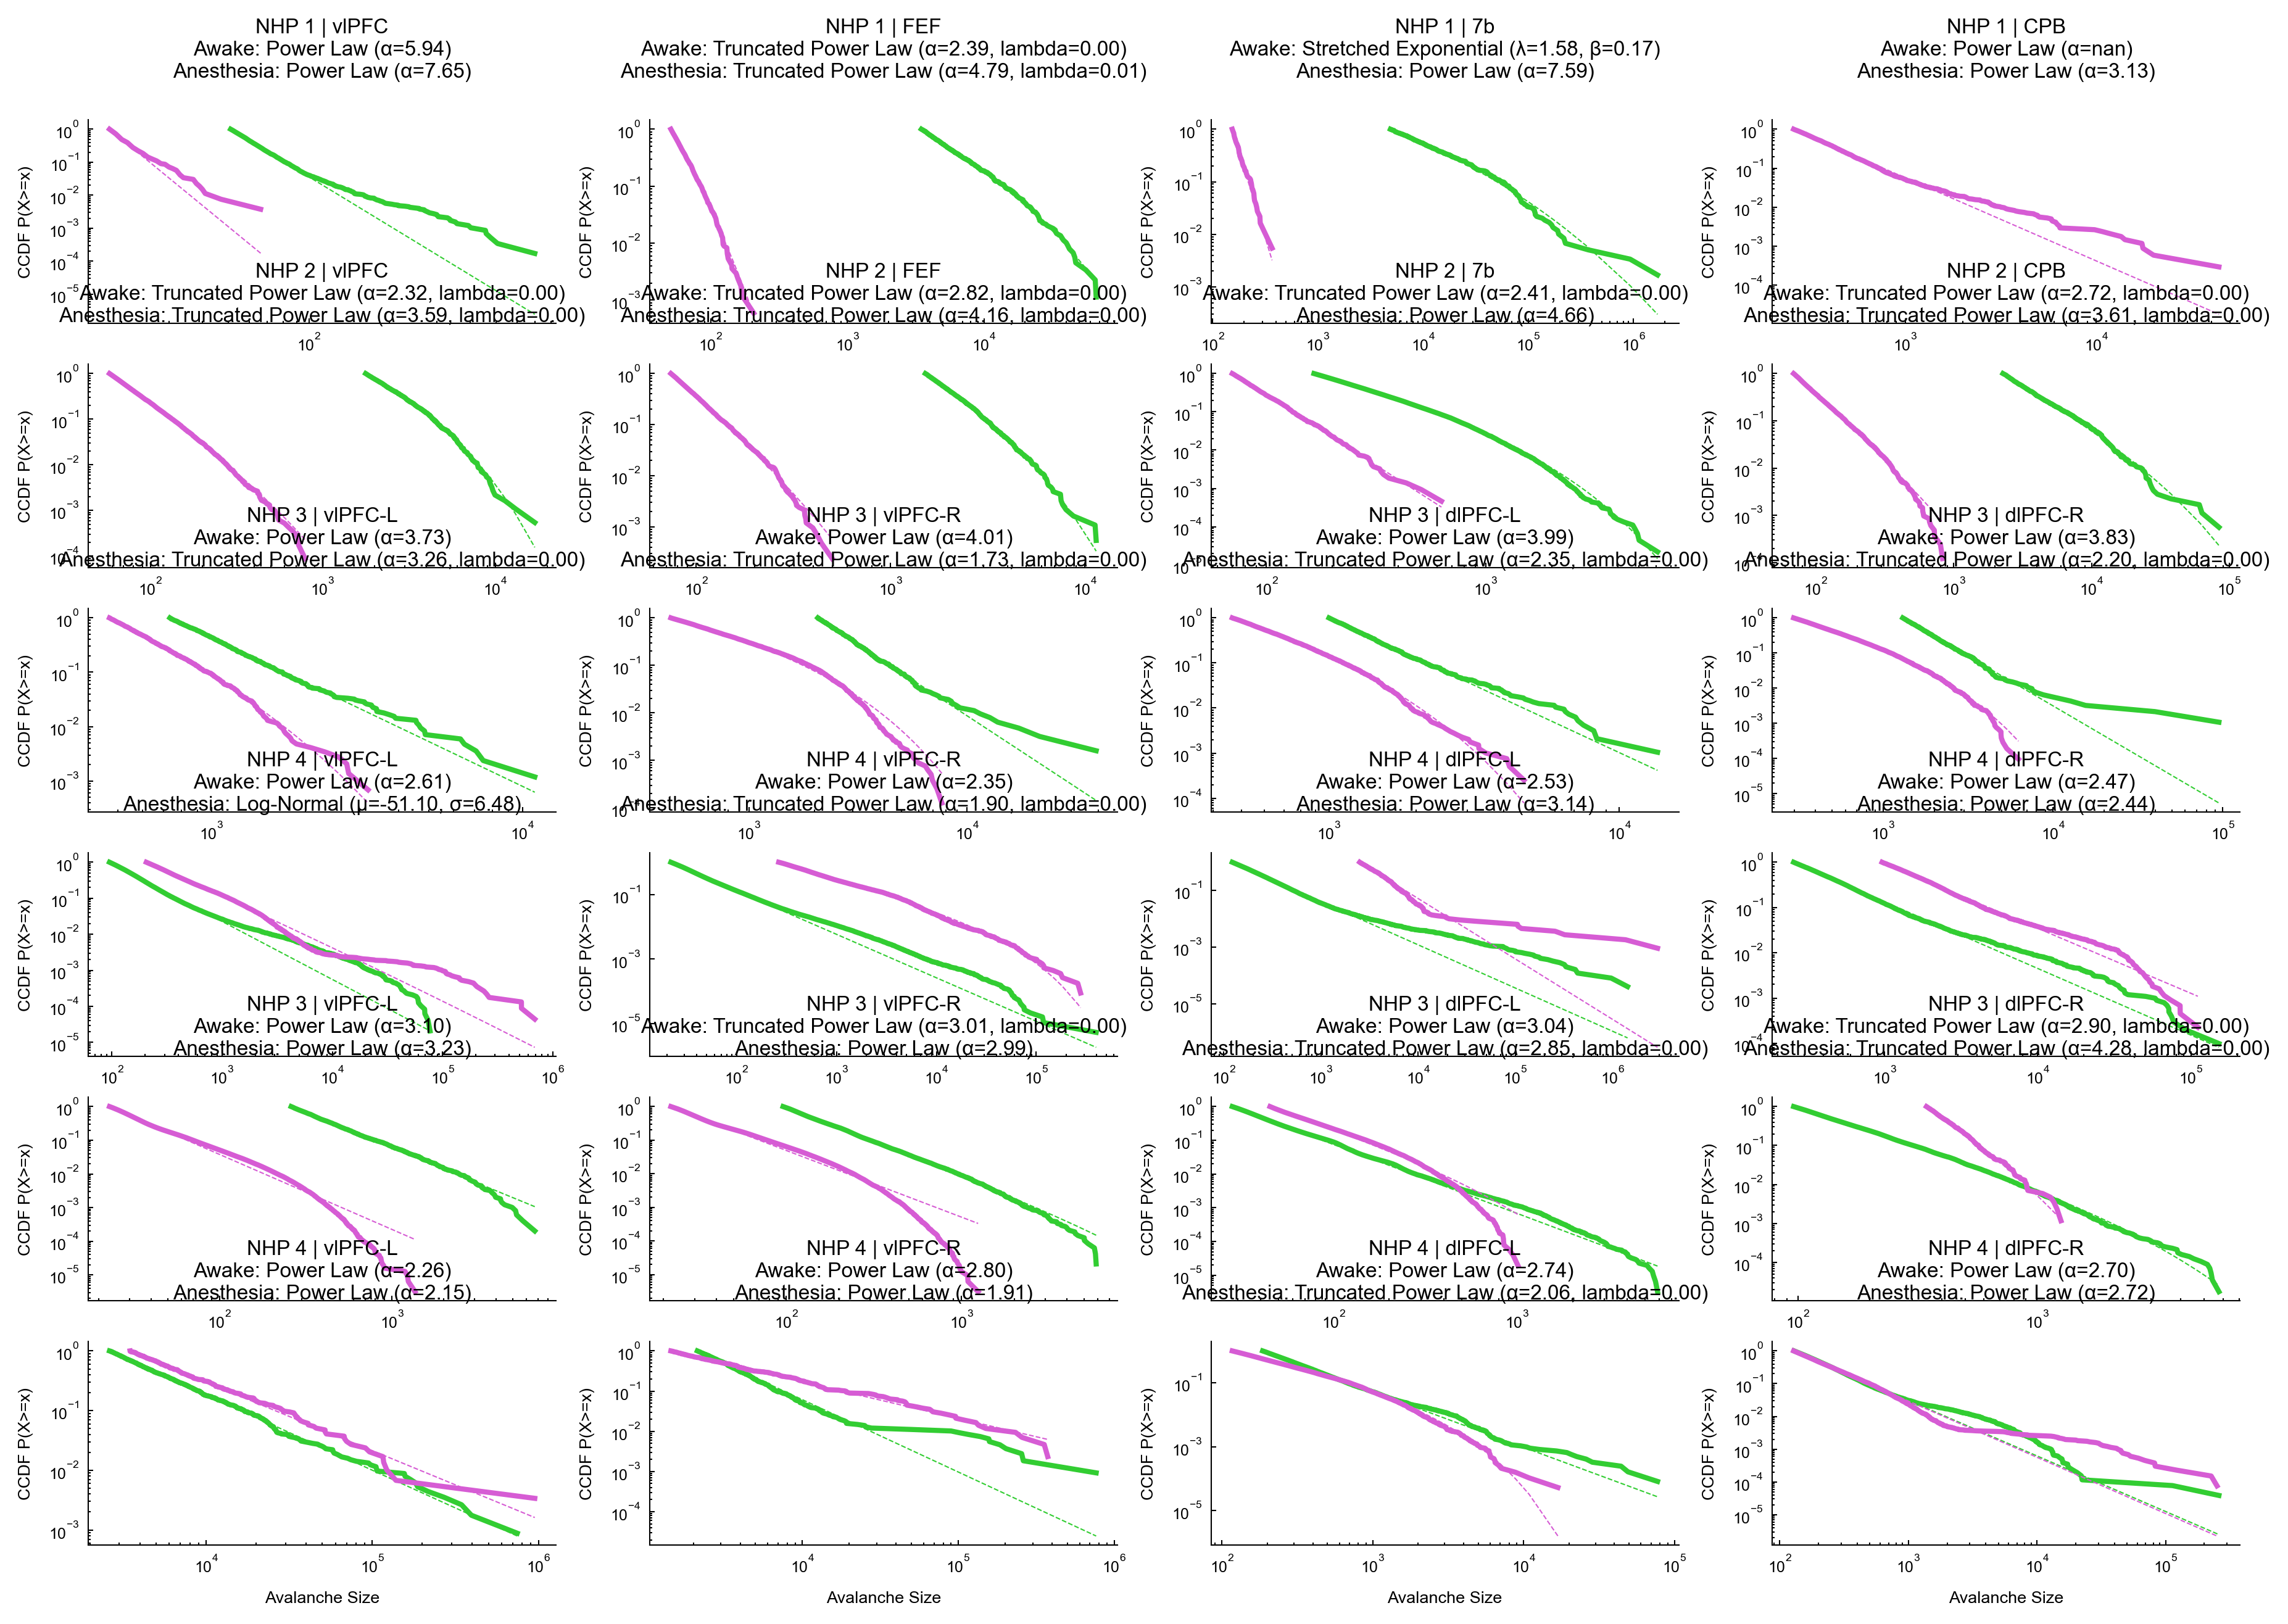

In [61]:
if num_plots >= 4:
    fig, axs = plt.subplots(int(num_plots/4), 4, figsize=(15, 10))
else:
    fig, axs = plt.subplots(1, num_plots, figsize=(6, 2))

# bin_size = 'optimal'
plot_num = 0
for i, (data_class, agent) in enumerate(anesthetic_agent_list):
    if (data_class, agent) not in avalanche_analysis_data:
        continue
    for monkey in avalanche_analysis_data[(data_class, agent)].keys():
        for area in avalanche_analysis_data[(data_class, agent)][monkey].keys():
            if num_plots >= 4:
                ax = axs[int(plot_num/4), plot_num%4]
            else:
                ax = axs[plot_num]
            param_str = ''
            for section in ['Awake', 'Anesthesia']:
                fit = avalanche_analysis_data[(data_class, agent)][monkey][area]['distribution_fits'][section]['fit']
                fit_name = avalanche_analysis_data[(data_class, agent)][monkey][area]['distribution_fits'][section]['results'][0]['name']
                # print(f"Monkey: {monkey}, Area: {area}, Section: {section}, Fit: {fit_name}")
                color = cfg.plotting.epoch_colors[section.lower()]
                fit.plot_ccdf(ax=ax, linewidth=2, label=f'{section} Empirical Data', color=color)
                if fit_name == 'truncated_power_law':
                    param_str += f'{section}: Truncated Power Law (α={fit.truncated_power_law.alpha:.2f}, lambda={fit.truncated_power_law.Lambda:.2f})\n'
                    fit.truncated_power_law.plot_ccdf(ax=ax, color=color, linestyle='--', label=param_str)
                elif fit_name == 'lognormal':
                    param_str += f'{section}: Log-Normal (μ={fit.lognormal.mu:.2f}, σ={fit.lognormal.sigma:.2f})\n'
                    fit.lognormal.plot_ccdf(ax=ax, color=color, linestyle='--', label=param_str)
                elif fit_name == 'stretched_exponential':
                    param_str += f'{section}: Stretched Exponential (λ={fit.stretched_exponential.Lambda:.2f}, β={fit.stretched_exponential.beta:.2f})\n'
                    fit.stretched_exponential.plot_ccdf(ax=ax, color=color, linestyle='--', label=param_str)
                elif fit_name == 'power_law':
                    param_str += f'{section}: Power Law (α={fit.power_law.alpha:.2f})\n'
                    fit.power_law.plot_ccdf(ax=ax, color=color, linestyle='--', label=param_str)
                else:
                    print(f"{area} {monkey} {section} {fit_name}")
            plot_num += 1
            
            ax.set_title(f'{monkey_name_map[monkey]} | {area}\n{param_str}')
            ax.set_xlabel('Avalanche Size')
            ax.set_ylabel('CCDF P(X>=x)')
            # ax.legend()
# plt.grid(True, which="both", ls="--")
plt.show()

# Code for avalanche analysis


In [ ]:
def bin_spikes(spike_times, bin_size):
    """
    Bins spike trains into a binary matrix (raster).

    Args:
        spike_times (list of lists): A list where each element is a list of spike
                                     times for a single neuron.
        num_neurons (int): The total number of neurons.
        bin_size (float): The time duration for each bin (in units of s).

    Returns:
        np.ndarray: A binary matrix of shape (num_neurons, num_bins).
        float: The duration of the recording.
    """
    # Find the last spike time to determine the recording duration
    num_neurons = len(spike_times)
    last_spike = np.max([max(st) for st in spike_times if len(st) > 0])
    duration = last_spike

    # Calculate the number of bins
    num_bins = int(np.ceil(duration / bin_size))

    # Create an empty raster plot
    raster = np.zeros((num_neurons, num_bins), dtype=int)

    # Populate the raster
    for i, neuron_spikes in enumerate(spike_times):
        for spike_time in neuron_spikes:
            bin_index = int(spike_time / bin_size)
            if bin_index < num_bins:
                raster[i, bin_index] = 1

    return raster, duration

def calculate_optimal_bin_size(spike_times, return_ieis=False):
    """
    Calculates the optimal bin size as the average inter-event interval (IEI).
    """
    # Flatten all spike times into a single list and sort them
    all_spikes = sorted([spike for neuron in spike_times for spike in neuron])

    if len(all_spikes) < 2:
        raise ValueError("Not enough spikes to calculate inter-event interval.")

    # Calculate the differences between consecutive spikes
    ieis = np.diff(all_spikes)

    # The optimal bin size is the average IEI
    if return_ieis:
        return np.mean(ieis), ieis
    else:
        return np.mean(ieis)

import powerlaw

def find_avalanches(raster):
    """
    Identifies neuronal avalanches from a binned spike raster.

    Args:
        raster (np.ndarray): The binned spike data (neurons x time bins).

    Returns:
        tuple: A tuple containing two lists:
               - A list of avalanche sizes.
               - A list of avalanche durations.
    """
    # Sum activity across neurons for each time bin
    activity_over_time = np.sum(raster, axis=0)
    sizes = []
    durations = []
    
    is_avalanche = False
    current_size = 0
    current_duration = 0

    for activity in activity_over_time:
        if activity > 0:
            is_avalanche = True
            current_size += activity
            current_duration += 1
        elif is_avalanche: # The avalanche has just ended
            sizes.append(current_size)
            durations.append(current_duration)
            # Reset for the next avalanche
            is_avalanche = False
            current_size = 0
            current_duration = 0
            
    # Add the last avalanche if the recording ends during one
    if is_avalanche:
        sizes.append(current_size)
        durations.append(current_duration)

    return sizes, durations

def fit_power_law(data, label, xmin=None, discrete=True):
    """
    Fits a power law to data and plots the distribution.

    Args:
        data (list): A list of avalanche sizes or durations.
        label (str): Label for the plot title (e.g., 'Avalanche Sizes').
        
    Returns:
        powerlaw.Fit: The fitted powerlaw object.
    """
    if not data:
        print(f"No data to fit for {label}.")
        return None
        
    # The 'powerlaw' package automatically finds the optimal x_min
    fit = powerlaw.Fit(data, xmin=xmin, discrete=discrete)
    
    print(f"\n--- {label} Analysis ---")
    print(f"Exponent (alpha): {fit.power_law.alpha:.4f}")
    print(f"Lower bound (x_min): {fit.power_law.xmin}")
    
    # Goodness-of-fit test (p-value)
    # R is the loglikelihood ratio between power law and a competing distribution
    # If R > 0, the power law is a better fit than the competing distribution
    # p is the significance of R
    # R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
    R, p = fit.distribution_compare('power_law', 'lognormal', normalized_ratio=True)
    print(f"Loglikelihood Ratio (vs Log-Normal): {R:.4f}")
    print(f"p-value: {p:.4f}")

    # Plotting
    fig, ax = plt.subplots()
    fit.plot_ccdf(ax=ax, color='b', linewidth=2, label='Empirical Data')
    fit.power_law.plot_ccdf(ax=ax, color='r', linestyle='--', label=f'Power Law Fit (α={fit.power_law.alpha:.2f})')
    fit.truncated_power_law.plot_ccdf(ax=ax, color='g', linestyle='--', label=f'Truncated Power Law Fit (α={fit.truncated_power_law.alpha:.2f}, λ={fit.truncated_power_law.Lambda:.2f})')
    fit.lognormal.plot_ccdf(ax=ax, color='y', linestyle='--', label=f'Log-Normal Fit (μ={fit.lognormal.mu:.2f}, σ={fit.lognormal.sigma:.2f})')
    fit.exponential.plot_ccdf(ax=ax, color='m', linestyle='--', label=f'Exponential Fit (λ={fit.exponential.Lambda:.2f})')
    
    ax.set_title(f'Log-Log Plot of {label} Distribution')
    ax.set_xlabel(label.split(' ')[1])
    ax.set_ylabel('CCDF P(X>=x)')
    ax.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

    return fit

def calculate_dcc(data, data_type='size'):
    """
    Calculates the Deviation from Criticality Coefficient (DCC).
    
    Ref: Shew, et al. (2009), "Neuronal Avalanches Imply Maximum Dynamic Range..."
    
    Args:
        data (list): A list of avalanche sizes or durations.
        data_type (str): 'size' or 'duration'. Determines the reference exponent.
    
    Returns:
        float: The DCC value.
    """
    if not data:
        return np.nan
        
    # Reference power-law exponents from theory/experiment
    ref_alpha = 1.5 if data_type == 'size' else 2.0
    
    # Use powerlaw to get the empirical CCDF
    fit = powerlaw.Fit(data, xmin=1, discrete=True, estimate_discrete=False)
    x = fit.ccdf()[0]
    y_data = fit.ccdf()[1]
    
    # Calculate the reference power-law CCDF
    # For a discrete power-law P(x) ~ x^-a, the CCDF is related to the Hurwitz zeta function.
    # For simplicity and as often done in practice, we approximate with the continuous form.
    # CCDF(x) = (x / xmin)^(-alpha + 1)
    y_ref = (x / 1.0)**(-ref_alpha + 1)

    # Calculate DCC as the mean squared error on a log-log scale
    dcc = np.sum((np.log10(y_data) - np.log10(y_ref))**2)
    
    return dcc / len(x)



import os
import numpy as np
import pandas as pd


def _is_powerlaw_object(obj):
    try:
        return type(obj).__module__.startswith('powerlaw')
    except Exception:
        return False


def _summarize_powerlaw_fit(obj):
    summary = {'__powerlaw__': type(obj).__name__}
    for attr in ('alpha', 'sigma', 'xmin', 'xmax', 'D', 'n', 'discrete', 'loglikelihood'):
        if hasattr(obj, attr):
            try:
                summary[attr] = getattr(obj, attr)
            except Exception:
                pass
    if hasattr(obj, 'distribution'):
        dist = getattr(obj, 'distribution')
        dist_name = getattr(dist, 'name', type(dist).__name__)
        summary['distribution'] = {'name': dist_name}
        for attr in ('alpha', 'xmin', 'xmax', 'discrete'):
            if hasattr(dist, attr):
                try:
                    summary[f'dist_{attr}'] = getattr(dist, attr)
                except Exception:
                    pass
    return summary


def _make_hashable_key(key):
    if key is None or isinstance(key, (bool, int, float, str)):
        return key
    if isinstance(key, np.generic):
        return key.item()
    try:
        hash(key)
        return repr(key)
    except Exception:
        return repr(key)


def _make_serializable(obj, _seen=None):
    if _seen is None:
        _seen = set()
    obj_id = id(obj)
    if obj_id in _seen:
        return '<cycle>'
    _seen.add(obj_id)

    if obj is None or isinstance(obj, (bool, int, float, str)):
        return obj

    if isinstance(obj, np.generic):
        return obj.item()

    if isinstance(obj, np.ndarray):
        return obj.copy()

    try:
        import pandas as pd  # ensure pandas types resolve even if not imported globally
        if isinstance(obj, (pd.DataFrame, pd.Series, pd.Index)):
            return obj.copy(deep=False)
    except Exception:
        pass

    if _is_powerlaw_object(obj):
        return _summarize_powerlaw_fit(obj)

    if isinstance(obj, dict):
        return { _make_hashable_key(k): _make_serializable(v, _seen) for k, v in obj.items() }

    if isinstance(obj, (list, tuple, set)):
        seq = [ _make_serializable(v, _seen) for v in obj ]
        return seq if not isinstance(obj, tuple) else tuple(seq)

    for method in ('to_dict', 'tolist', 'as_dict'):
        if hasattr(obj, method) and callable(getattr(obj, method)):
            try:
                return _make_serializable(getattr(obj, method)(), _seen)
            except Exception:
                pass

    try:
        return repr(obj)
    except Exception:
        return f'<unserializable {type(obj).__name__}>'


def sanitize_avalanche_analysis_data(avalanche_fits):
    return _make_serializable(avalanche_fits)


def save_avalanche_analysis_data(avalanche_fits, avalanche_data_dir, filename='avalanche_analysis_fits_dict.pkl'):
    san = sanitize_avalanche_analysis_data(avalanche_fits)
    base, ext = os.path.splitext(avalanche_data_dir)
    if ext:
        out_path = avalanche_data_dir
    else:
        out_path = os.path.join(avalanche_data_dir, filename)
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    pd.to_pickle(san, out_path)
    return out_path


# Analyze avalanches

In [ ]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list

In [7]:
# avalanche_analysis_data = {}

# # bin_sizes = [0.001, 0.002, 0.004, 0.008, 0.016]
# bin_sizes = []
# use_individiual_areas = True

# for data_class, agent in tqdm(anesthetic_agent_list):
#     if agent != 'propofol':
#         continue

#     avalanche_analysis_data[(data_class, agent)] = {}

#     # if agent == 'propofol':
#     #     cfg.params.grid_set = 'grid_set5'
#     # else:
#     #     cfg.params.grid_set = 'grid_set4'
#     cfg.params.grid_set = 'grid_set6'

#     cfg.params.data_class = data_class
#     if 'propofol' in cfg.params.data_class:
#         session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class)) if f.endswith('.mat')]
#         # areas = ['all'] if not use_individiual_areas else ['vlPFC', 'FEF', '7b', 'CPB']
#         areas = ['all'] if not use_individiual_areas else ['vlPFC']
#         data_dir = os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class)
#         # areas = ['all', 'vlPFC', 'FEF', '7b', 'CPB']
#     else:
#         session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat')) if f.endswith('.mat')]
#         data_dir = os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat')
#         session_list = [session for session in session_list if session not in ['PEDRI_Ketamine_20220203']]
#         # bad_session_list = ['PEDRI_Ketamine_20220113', 'PEDRI_Ketamine_20220126', 'PEDRI_Ketamine_20220203', 'PEDRI_Ketamine_20220222', 'SPOCK_Ketamine_20210722', 'SPOCK_Ketamine_20210730']
#         # session_list = [session for session in session_list if session not in bad_session_list]
#         session_list = [session for session in session_list if agent.lower()[:3] in session.lower()]
#         areas = ['all'] if not use_individiual_areas else ['vlPFC-L', 'vlPFC-R', 'dlPFC-L', 'dlPFC-R']
#         # areas = ['all', 'vlPFC-L', 'vlPFC-R', 'dlPFC-L', 'dlPFC-R']

#         # get only high dose sessions
#         high_dose_session_list = []
#         for session in session_list:
#             session_file = h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', session + '.mat'), 'r')
#             dose = session_file['sessionInfo']['dose'][0, 0]
#             if dose > 9:
#                 high_dose_session_list.append(session)
#         session_list = high_dose_session_list
    

#     session_lists, locs, rocs, ropaps = get_all_session_loc_roc_info(cfg, session_list, verbose=False)

#     for area in areas:
#         avalanche_analysis_data[(data_class, agent)][area] = {}
#         for monkey in session_lists.keys():
#             avalanche_analysis_data[(data_class, agent)][area][monkey] = {}
#             avalanche_analysis_data[(data_class, agent)][area][monkey]['session_data'] = {}
#             for session in tqdm(session_lists[monkey]['high']):
#                 session_file = h5py.File(os.path.join(data_dir,f"{session}.mat"), 'r')
#                 section_info, section_info_extended, section_colors, infusion_start = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class, section_info_type='plot')

#                 unit_areas = convert_h5_string_array(session_file, session_file['unitInfo']['area'][0])

#                 if cfg.params.data_class == 'anesthesiaLvrOdd':
#                     hemispheres = convert_h5_string_array(session_file, session_file['unitInfo']['hemisphere'])
#                     hemispheres = [h[0].capitalize() for h in hemispheres]
#                     unit_areas = [f"{a}-{h}" for a, h in zip(unit_areas, hemispheres)]

#                 avalanche_analysis_data[(data_class, agent)][area][monkey]['session_data'][session] = {}
                
#                 for section in ['Awake', 'Anesthesia']:
#                     avalanche_analysis_data[(data_class, agent)][area][monkey]['session_data'][session][section] = {}
#                     spike_times_lists = []
#                     print(f"Processing {session} {section} {area}")
#                     for i in range(session_file['spikeTimes'].shape[0]):
#                         if area == 'all' or unit_areas[i] == area:
                            
#                             spike_times_ref = session_file['spikeTimes'][i, 0]
#                             spike_times_dataset = session_file[spike_times_ref]
#                             neuron_spikes = spike_times_dataset[:, 0]
#                             section_start, section_end = section_info[np.where([info[0] == section for info in section_info])[0][0]][1]
#                             section_start = section_start*60 + infusion_start
#                             section_end = section_end*60 + infusion_start
#                             neuron_spikes = neuron_spikes[neuron_spikes > section_start]
#                             neuron_spikes = neuron_spikes[neuron_spikes < section_end]
#                             spike_times_lists.append(neuron_spikes)
#                     avalanche_analysis_data[(data_class, agent)][area][monkey]['session_data'][session][section]['spike_times_lists'] = spike_times_lists
#                     optimal_bin_size, ieis = calculate_optimal_bin_size(spike_times_lists, return_ieis=True)
#                     avalanche_analysis_data[(data_class, agent)][area][monkey]['session_data'][session][section]['optimal'] = {}
#                     avalanche_analysis_data[(data_class, agent)][area][monkey]['session_data'][session][section]['optimal']['bin_size'] = optimal_bin_size
#                     avalanche_analysis_data[(data_class, agent)][area][monkey]['session_data'][session][section]['optimal']['ieis'] = ieis
#                     # print(f"Optimal Bin Size (Average IEI): {optimal_bin_size:.4f} seconds")

#                     binned_raster, rec_duration = bin_spikes(spike_times_lists, optimal_bin_size)
#                     avalanche_analysis_data[(data_class, agent)][area][monkey]['session_data'][session][section]['optimal']['binned_raster'] = binned_raster
#                     # print(f"Data binned into a {binned_raster.shape} raster.")

#                     avalanche_sizes, avalanche_durations = find_avalanches(binned_raster)
#                     avalanche_analysis_data[(data_class, agent)][area][monkey]['session_data'][session][section]['optimal']['avalanche_sizes'] = avalanche_sizes
#                     # print(f"Found {len(avalanche_sizes)} avalanches.")

#                     for bin_size in bin_sizes:
#                         avalanche_analysis_data[(data_class, agent)][area][monkey]['session_data'][session][section][bin_size] = {}
#                         avalanche_analysis_data[(data_class, agent)][area][monkey]['session_data'][session][section][bin_size]['bin_size'] = bin_size
#                         binned_raster, rec_duration = bin_spikes(spike_times_lists, bin_size)
#                         avalanche_analysis_data[(data_class, agent)][area][monkey]['session_data'][session][section][bin_size]['binned_raster'] = binned_raster
#                         # print(f"Data binned into a {binned_raster.shape} raster.")

#                         avalanche_sizes, avalanche_durations = find_avalanches(binned_raster)
#                         avalanche_analysis_data[(data_class, agent)][area][monkey]['session_data'][session][section][bin_size]['avalanche_sizes'] = avalanche_sizes

#             all_avalanche_sizes = {}
#             avalanche_fits = {}
#             for bin_size in ['optimal'] + bin_sizes:
#                 avalanche_fits[bin_size] = {}
#                 all_avalanche_sizes[bin_size] = {}
#                 for section in ['Awake', 'Anesthesia']:
#                     all_avalanche_sizes[bin_size][section] = []
#                     for session in avalanche_analysis_data[(data_class, agent)][area][monkey]['session_data']:
#                         all_avalanche_sizes[bin_size][section].extend(avalanche_analysis_data[(data_class, agent)][area][monkey]['session_data'][session][section][bin_size]['avalanche_sizes'])
#                     max_search_xmin = np.percentile(all_avalanche_sizes[bin_size][section], 20)
#                     if max_search_xmin <= 1:
#                         search_range = 1
#                     else:
#                         unique_sizes = np.unique(all_avalanche_sizes[bin_size][section])
#                         search_range = list(unique_sizes[unique_sizes <= max_search_xmin])

#                     results, fit = select_best_distribution(all_avalanche_sizes[bin_size][section], xmin_range=search_range)
#                     avalanche_fits[bin_size][section] = {'fit': fit, 'results': results}

#             for bin_size in avalanche_fits:
#                 for section in avalanche_fits[bin_size]:
#                     all_xmins = [avalanche_fits[bin_size][section]['fit'].xmin for section in avalanche_fits[bin_size]]
#                     xmin = max(all_xmins)

#                     matching_xmin = [x == xmin for x in all_xmins]
#                     if np.sum(matching_xmin) != len(all_xmins):
#                         results, fit = select_best_distribution(all_avalanche_sizes[bin_size][section], xmin_range=xmin)
#                         avalanche_fits[bin_size][section]['results_xmin'] = results
#                         avalanche_fits[bin_size][section]['fit_xmin'] = fit
#                     else:
#                         avalanche_fits[bin_size][section]['results_xmin'] = avalanche_fits[bin_size][section]['results']
#                         avalanche_fits[bin_size][section]['fit_xmin'] = avalanche_fits[bin_size][section]['fit']
            
#             avalanche_analysis_data[(data_class, agent)][area][monkey]['avalanche_fits'] = avalanche_fits

#             for state in ['Awake', 'Anesthesia']:
#                 fit = avalanche_fits['optimal'][state]['fit_xmin']
#                 fit_name = avalanche_fits['optimal'][state]['results_xmin'][0]['name']
#                 print(f"Monkey: {monkey}, Area: {area}, State: {state}, Fit: {fit_name}")
            
#             del avalanche_analysis_data[(data_class, agent)][area][monkey]['session_data']

In [61]:
# Memory-safe avalanche analysis utilities
# - Uses context managers for HDF5
# - Avoids retaining large rasters
# - Accumulates avalanche sizes on the fly
# - Fixes variable shadowing in xmin harmonization


def analyze_avalanches_memory_safe(cfg, anesthetic_agent_list, use_individiual_areas=True, bin_sizes: List[float]=None) -> Dict[str, Any]:
    if bin_sizes is None:
        bin_sizes = []

    avalanche_analysis_data: Dict[str, Any] = {}

    # num sessions
    num_evals = 0
    for data_class, agent in anesthetic_agent_list:
        if agent != 'propofol':
            continue
        cfg.params.grid_set = 'grid_set6'
        cfg.params.data_class = data_class

        if 'propofol' in cfg.params.data_class:
            session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class)) if f.endswith('.mat')]
            # areas = ['all'] if not use_individiual_areas else ['vlPFC', 'FEF', '7b', 'CPB']
            areas = ['all'] if not use_individiual_areas else ['vlPFC']
            data_dir = os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class)
        else:
            session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat')) if f.endswith('.mat')]
            data_dir = os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat')
            session_list = [session for session in session_list if session not in ['PEDRI_Ketamine_20220203']]
            session_list = [session for session in session_list if agent.lower()[:3] in session.lower()]
            areas = ['all'] if not use_individiual_areas else ['vlPFC-L', 'vlPFC-R', 'dlPFC-L', 'dlPFC-R']

            # filter high dose sessions only
            high_dose_session_list = []
            for session in session_list:
                with h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', session + '.mat'), 'r') as session_file:
                    dose = session_file['sessionInfo']['dose'][0, 0]
                    if dose > 9:
                        high_dose_session_list.append(session)
            session_list = high_dose_session_list

        session_lists, locs, rocs, ropaps = get_all_session_loc_roc_info(cfg, session_list, verbose=False)

        for area in areas:
            for monkey in session_lists.keys():
                num_evals += 1

        
    iterator = tqdm(total=num_evals)
    for data_class, agent in anesthetic_agent_list:
        if agent != 'propofol':
            continue

        avalanche_analysis_data[(data_class, agent)] = {}

        cfg.params.grid_set = 'grid_set6'
        cfg.params.data_class = data_class

        if 'propofol' in cfg.params.data_class:
            session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class)) if f.endswith('.mat')]
            # areas = ['all'] if not use_individiual_areas else ['vlPFC', 'FEF', '7b', 'CPB']
            areas = ['all'] if not use_individiual_areas else ['vlPFC']
            data_dir = os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class)
        else:
            session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat')) if f.endswith('.mat')]
            data_dir = os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat')
            session_list = [session for session in session_list if session not in ['PEDRI_Ketamine_20220203']]
            session_list = [session for session in session_list if agent.lower()[:3] in session.lower()]
            areas = ['all'] if not use_individiual_areas else ['vlPFC-L', 'vlPFC-R', 'dlPFC-L', 'dlPFC-R']

            # filter high dose sessions only
            high_dose_session_list = []
            for session in session_list:
                with h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', session + '.mat'), 'r') as session_file:
                    dose = session_file['sessionInfo']['dose'][0, 0]
                    if dose > 9:
                        high_dose_session_list.append(session)
            session_list = high_dose_session_list

        session_lists, locs, rocs, ropaps = get_all_session_loc_roc_info(cfg, session_list, verbose=False)

        for area in areas:
            avalanche_analysis_data[(data_class, agent)][area] = {}
            for monkey in session_lists.keys():
                avalanche_analysis_data[(data_class, agent)][area][monkey] = {}

                # accumulate sizes per state/bin without keeping per-session rasters in memory
                all_avalanche_sizes: Dict[Any, Dict[str, List[int]]] = {}
                avalanche_fits: Dict[Any, Dict[str, Any]] = {}

                for bin_key in (['optimal'] + (bin_sizes or [])):
                    all_avalanche_sizes[bin_key] = {'Awake': [], 'Anesthesia': []}

                for session in session_lists[monkey]['high']:
                    with h5py.File(os.path.join(data_dir, f"{session}.mat"), 'r') as session_file:
                        section_info, section_info_extended, section_colors, infusion_start = get_section_info(
                            session, cfg.params.all_data_dir, cfg.params.data_class, section_info_type='plot'
                        )
                        unit_areas = convert_h5_string_array(session_file, session_file['unitInfo']['area'][0])
                        if cfg.params.data_class == 'anesthesiaLvrOdd':
                            hemispheres = convert_h5_string_array(session_file, session_file['unitInfo']['hemisphere'])
                            hemispheres = [h[0].capitalize() for h in hemispheres]
                            unit_areas = [f"{a}-{h}" for a, h in zip(unit_areas, hemispheres)]

                        for section in ['Awake', 'Anesthesia']:
                            spike_times_lists: List[np.ndarray] = []
                            for i in range(session_file['spikeTimes'].shape[0]):
                                if area == 'all' or unit_areas[i] == area:
                                    spike_times_ref = session_file['spikeTimes'][i, 0]
                                    spike_times_dataset = session_file[spike_times_ref]
                                    neuron_spikes = spike_times_dataset[:, 0]
                                    section_start, section_end = section_info[np.where([info[0] == section for info in section_info])[0][0]][1]
                                    section_start = section_start * 60 + infusion_start
                                    section_end = section_end * 60 + infusion_start
                                    neuron_spikes = neuron_spikes[(neuron_spikes > section_start) & (neuron_spikes < section_end)]
                                    spike_times_lists.append(neuron_spikes)

                            optimal_bin_size, ieis = calculate_optimal_bin_size(spike_times_lists, return_ieis=True)

                            # process optimal bin
                            binned_raster, rec_duration = bin_spikes(spike_times_lists, optimal_bin_size)
                            avalanche_sizes, avalanche_durations = find_avalanches(binned_raster)
                            all_avalanche_sizes['optimal'][section].extend(avalanche_sizes)
                            del binned_raster, avalanche_durations

                            # process any explicit bin sizes
                            for bin_size in (bin_sizes or []):
                                binned_raster, rec_duration = bin_spikes(spike_times_lists, bin_size)
                                avalanche_sizes, avalanche_durations = find_avalanches(binned_raster)
                                all_avalanche_sizes[bin_size][section].extend(avalanche_sizes)
                                del binned_raster, avalanche_durations

                            # free spike times list
                            del spike_times_lists

                # fit distributions after accumulating per-monkey
                for bin_key in all_avalanche_sizes.keys():
                    avalanche_fits[bin_key] = {}
                    for state in ['Awake', 'Anesthesia']:
                        sizes = all_avalanche_sizes[bin_key][state]
                        print(f"agent: {agent}, area: {area}, monkey: {monkey}, bin_key: {bin_key}, state: {state}")
                        plt.hist(sizes, bins=100)
                        plt.show()
                        if len(sizes) == 0:
                            avalanche_fits[bin_key][state] = {'fit': None, 'results': []}
                            continue

                        max_search_xmin = np.percentile(sizes, 20)
                        if max_search_xmin <= 1:
                            search_range = 1
                        else:
                            unique_sizes = np.unique(sizes)
                            search_range = list(unique_sizes[unique_sizes <= max_search_xmin])

                        results, fit = select_best_distribution(sizes, xmin_range=search_range)
                        avalanche_fits[bin_key][state] = {'fit': fit, 'results': results}

                # harmonize xmin across states per bin_key (fix shadowing)
                for bin_key in avalanche_fits:
                    states = list(avalanche_fits[bin_key].keys())
                    all_xmins = [avalanche_fits[bin_key][state]['fit'].xmin for state in states if avalanche_fits[bin_key][state]['fit'] is not None]
                    if len(all_xmins) == 0:
                        continue
                    common_xmin = max(all_xmins)

                    for state in states:
                        fit_obj = avalanche_fits[bin_key][state]['fit']
                        if fit_obj is None:
                            continue
                        if fit_obj.xmin != common_xmin:
                            sizes = all_avalanche_sizes[bin_key][state]
                            results, fit = select_best_distribution(sizes, xmin_range=common_xmin)
                            avalanche_fits[bin_key][state]['results_xmin'] = results
                            avalanche_fits[bin_key][state]['fit_xmin'] = fit
                        else:
                            avalanche_fits[bin_key][state]['results_xmin'] = avalanche_fits[bin_key][state]['results']
                            avalanche_fits[bin_key][state]['fit_xmin'] = avalanche_fits[bin_key][state]['fit']

                avalanche_analysis_data[(data_class, agent)][area][monkey]['avalanche_fits'] = avalanche_fits

                # # save avalanche fits
                # save_avalanche_analysis_data(avalanche_fits, os.path.join(avalanche_data_dir, f'{agent}_{area}_{monkey}.pkl'))

                for state in ['Awake', 'Anesthesia']:
                    fit = avalanche_fits['optimal'][state].get('fit_xmin')
                    fit_name = avalanche_fits['optimal'][state].get('results_xmin', [{}])[0].get('name') if avalanche_fits['optimal'][state].get('results_xmin') else None
                    print(f"Monkey: {monkey}, Area: {area}, State: {state}, Fit: {fit_name}")

                iterator.update(1)
    iterator.close()
    return avalanche_analysis_data



  0%|          | 0/2 [00:00<?, ?it/s]

agent: propofol, area: vlPFC, monkey: Mary, bin_key: optimal, state: Awake


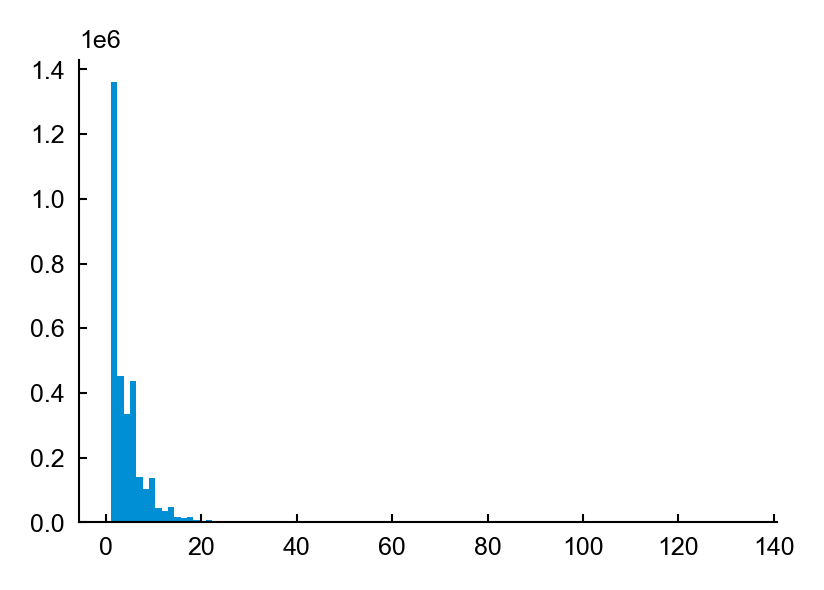

Constraining xmin search to the range 1

Optimal xmin for Power Law found at: 1.00
Number of data points in tail (n_tail): 3166719.0

Calculating AIC/BIC for all candidate distributions...
agent: propofol, area: vlPFC, monkey: Mary, bin_key: optimal, state: Anesthesia


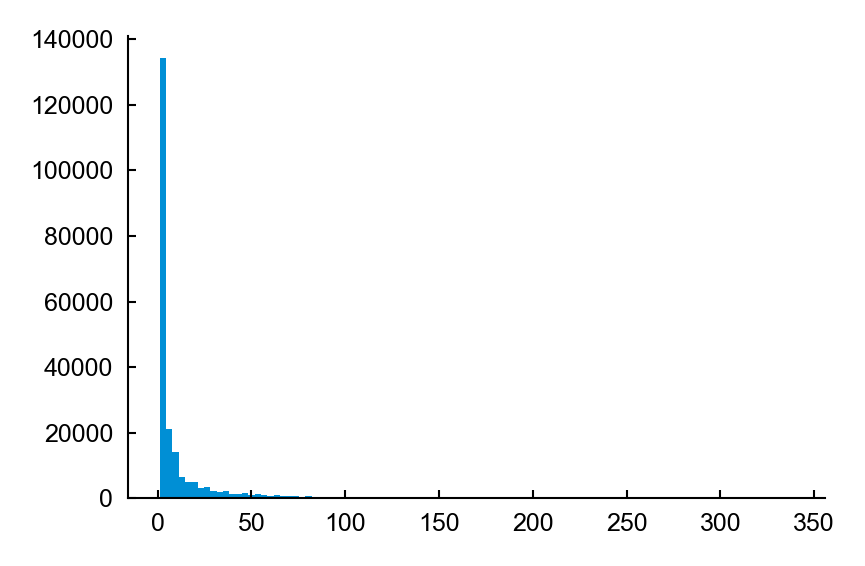

Constraining xmin search to the range 1

Optimal xmin for Power Law found at: 1.00
Number of data points in tail (n_tail): 217328.0

Calculating AIC/BIC for all candidate distributions...
agent: propofol, area: vlPFC, monkey: Mary, bin_key: 0.01, state: Awake


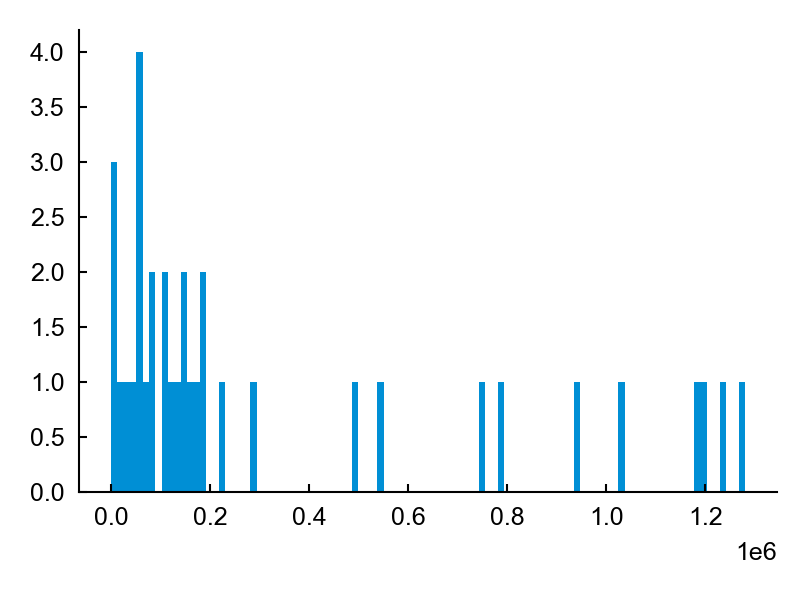

Constraining xmin search to the range [np.int64(37), np.int64(6500), np.int64(9758), np.int64(16334), np.int64(31250), np.int64(50039), np.int64(51644)]
xmin progress: 83%
Optimal xmin for Power Law found at: 50039.00
Number of data points in tail (n_tail): 30.0

Calculating AIC/BIC for all candidate distributions...
agent: propofol, area: vlPFC, monkey: Mary, bin_key: 0.01, state: Anesthesia


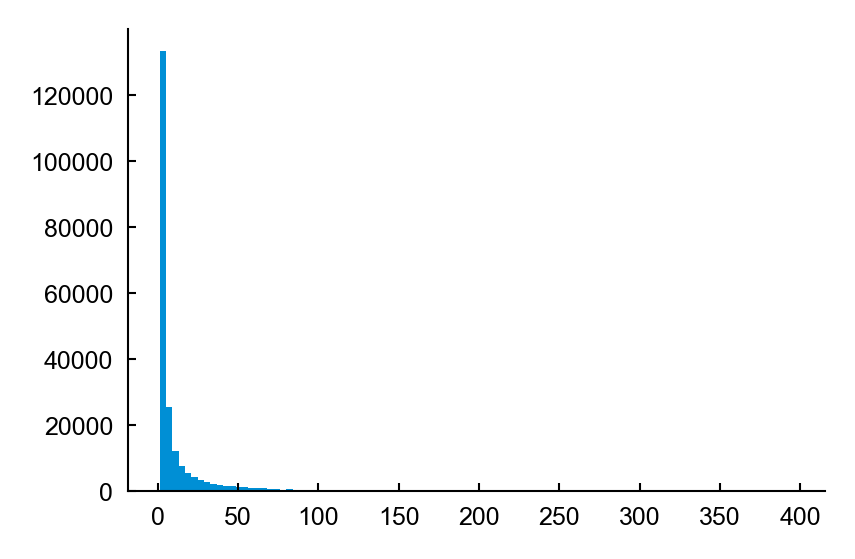

Constraining xmin search to the range 1

Optimal xmin for Power Law found at: 1.00
Number of data points in tail (n_tail): 216364.0

Calculating AIC/BIC for all candidate distributions...
Constraining xmin search to the range 50039.0

Optimal xmin for Power Law found at: 50039.00
Number of data points in tail (n_tail): 0.0

Calculating AIC/BIC for all candidate distributions...
Monkey: Mary, Area: vlPFC, State: Awake, Fit: truncated_power_law
Monkey: Mary, Area: vlPFC, State: Anesthesia, Fit: truncated_power_law


/om2/user/eisenaj/miniforge3/envs/universal-unconsciousness/lib/python3.11/site-packages/powerlaw.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
/om2/user/eisenaj/miniforge3/envs/universal-unconsciousness/lib/python3.11/site-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in scalar divide
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
Not enough data. Returning nan
/tmp/ipykernel_3675445/1191505176.py:231: RuntimeWarning: divide by zero encountered in log
  bic = k * np.log(n) - 2 * log_likelihood
/om2/user/eisenaj/miniforge3/envs/universal-unconsciousness/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/om2/user/eisenaj/miniforge3/envs/universal-unconsciousness/lib/python3.11/site-packages/num

agent: propofol, area: vlPFC, monkey: MrJones, bin_key: optimal, state: Awake


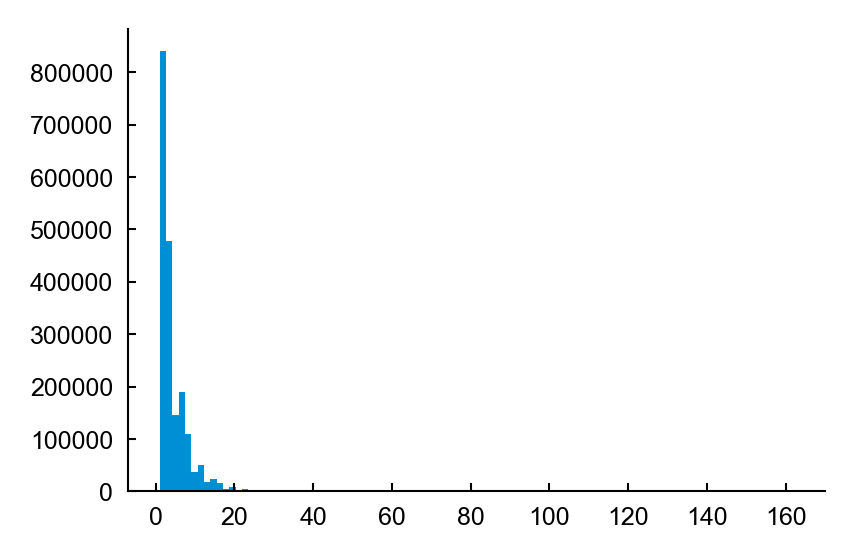

Constraining xmin search to the range 1

Optimal xmin for Power Law found at: 1.00
Number of data points in tail (n_tail): 1937680.0

Calculating AIC/BIC for all candidate distributions...
agent: propofol, area: vlPFC, monkey: MrJones, bin_key: optimal, state: Anesthesia


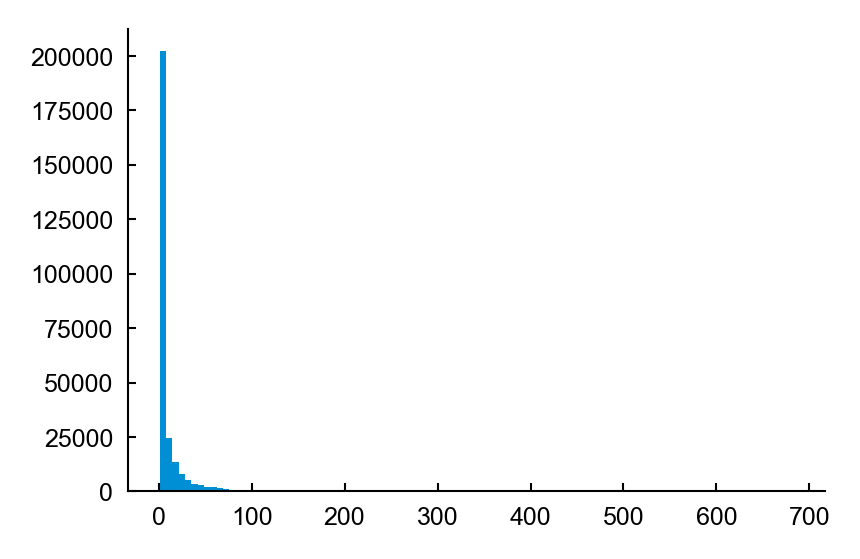

Constraining xmin search to the range 1

Optimal xmin for Power Law found at: 1.00
Number of data points in tail (n_tail): 274235.0

Calculating AIC/BIC for all candidate distributions...


/om2/user/eisenaj/miniforge3/envs/universal-unconsciousness/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


agent: propofol, area: vlPFC, monkey: MrJones, bin_key: 0.01, state: Awake


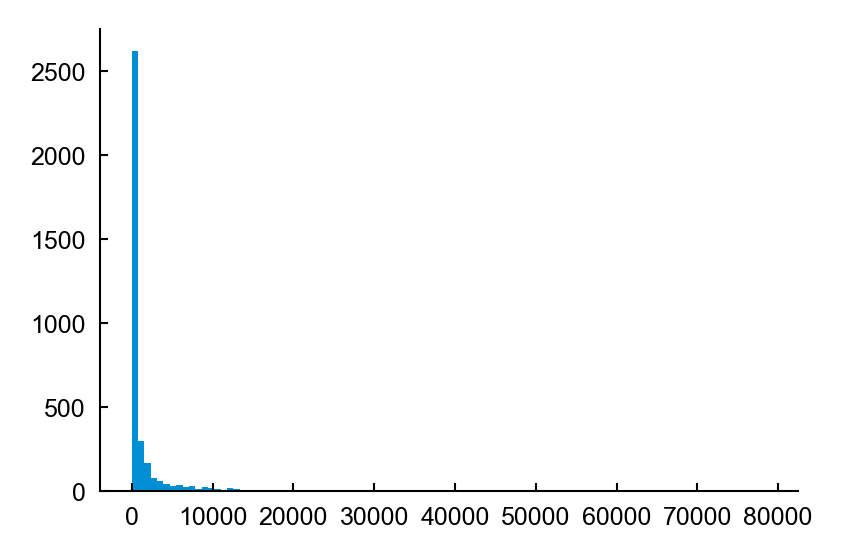

Constraining xmin search to the range [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)]
xmin progress: 90%
Optimal xmin for Power Law found at: 11.00
Number of data points in tail (n_tail): 2952.0

Calculating AIC/BIC for all candidate distributions...
agent: propofol, area: vlPFC, monkey: MrJones, bin_key: 0.01, state: Anesthesia


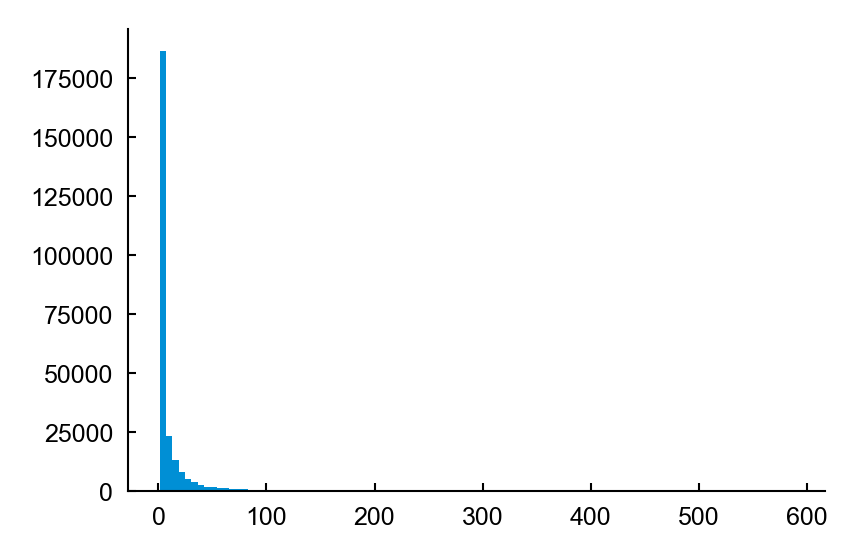

Constraining xmin search to the range 1

Optimal xmin for Power Law found at: 1.00
Number of data points in tail (n_tail): 259659.0

Calculating AIC/BIC for all candidate distributions...


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Constraining xmin search to the range 11.0

Optimal xmin for Power Law found at: 11.00
Number of data points in tail (n_tail): 56049.0

Calculating AIC/BIC for all candidate distributions...
Monkey: MrJones, Area: vlPFC, State: Awake, Fit: truncated_power_law
Monkey: MrJones, Area: vlPFC, State: Anesthesia, Fit: truncated_power_law


In [63]:
# avalanche_analysis_data = analyze_avalanches_memory_safe(cfg, anesthetic_agent_list, use_individiual_areas=True, bin_sizes=[0.0005, 0.001, 0.002, 0.005, 0.01, 0.02])
avalanche_analysis_data = analyze_avalanches_memory_safe(cfg, anesthetic_agent_list, use_individiual_areas=True, bin_sizes=[0.01])

In [68]:
# data_class, agent = ('anesthesiaLvrOdd', 'ketamine')
# area = 'dlPFC-R'
# monkey = 'PEDRI'

data_class, agent = ('propofolPuffTone', 'propofol')
area = 'vlPFC'
monkey = 'MrJones'

num_plots = 0
for data_class, agent in anesthetic_agent_list:
    if (data_class, agent) in avalanche_analysis_data:
        for area in avalanche_analysis_data[(data_class, agent)].keys():
            for monkey in avalanche_analysis_data[(data_class, agent)][area].keys():
                num_plots += 1

num_plots


2

In [69]:
monkey_name_map = {
    'Mary': 'NHP 1',
    'MrJones': 'NHP 2',
    'SPOCK': 'NHP 3',
    'PEDRI': 'NHP 4',
}

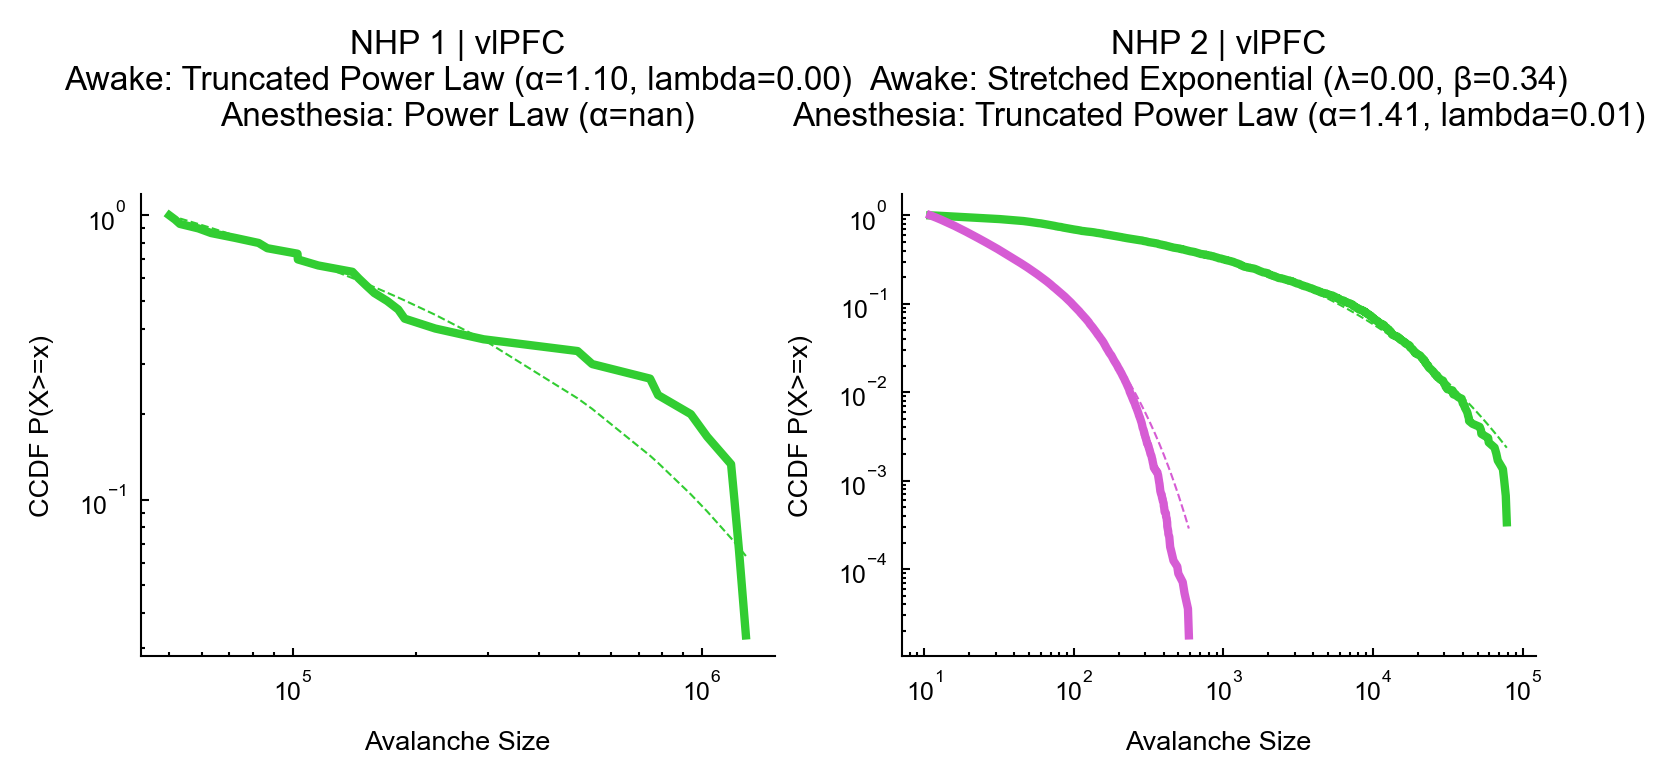

In [70]:
if num_plots >= 4:
    fig, axs = plt.subplots(int(num_plots/4), 4, figsize=(15, 10))
else:
    fig, axs = plt.subplots(1, num_plots, figsize=(6, 2))

# bin_size = 'optimal'
bin_size = 0.01
plot_num = 0
for i, (data_class, agent) in enumerate(anesthetic_agent_list):
    if (data_class, agent) not in avalanche_analysis_data:
        continue
    for area in avalanche_analysis_data[(data_class, agent)].keys():
        for monkey in avalanche_analysis_data[(data_class, agent)][area].keys():
            if num_plots >= 4:
                ax = axs[int(plot_num/4), plot_num%4]
            else:
                ax = axs[plot_num]
            param_str = ''
            for section in ['Awake', 'Anesthesia']:
                fit = avalanche_analysis_data[(data_class, agent)][area][monkey]['avalanche_fits'][bin_size][section]['fit_xmin']
                fit_name = avalanche_analysis_data[(data_class, agent)][area][monkey]['avalanche_fits'][bin_size][section]['results_xmin'][0]['name']
                # print(f"Monkey: {monkey}, Area: {area}, Section: {section}, Fit: {fit_name}")
                color = cfg.plotting.epoch_colors[section.lower()]
                fit.plot_ccdf(ax=ax, linewidth=2, label=f'{section} Empirical Data', color=color)
                if fit_name == 'truncated_power_law':
                    param_str += f'{section}: Truncated Power Law (α={fit.truncated_power_law.alpha:.2f}, lambda={fit.truncated_power_law.Lambda:.2f})\n'
                    fit.truncated_power_law.plot_ccdf(ax=ax, color=color, linestyle='--', label=param_str)
                elif fit_name == 'lognormal':
                    param_str += f'{section}: Log-Normal (μ={fit.lognormal.mu:.2f}, σ={fit.lognormal.sigma:.2f})\n'
                    fit.lognormal.plot_ccdf(ax=ax, color=color, linestyle='--', label=param_str)
                elif fit_name == 'stretched_exponential':
                    param_str += f'{section}: Stretched Exponential (λ={fit.stretched_exponential.Lambda:.2f}, β={fit.stretched_exponential.beta:.2f})\n'
                    fit.stretched_exponential.plot_ccdf(ax=ax, color=color, linestyle='--', label=param_str)
                elif fit_name == 'power_law':
                    param_str += f'{section}: Power Law (α={fit.power_law.alpha:.2f})\n'
                    fit.power_law.plot_ccdf(ax=ax, color=color, linestyle='--', label=param_str)
                else:
                    print(f"{area} {monkey} {section} {fit_name}")
            plot_num += 1
            
            ax.set_title(f'{monkey_name_map[monkey]} | {area}\n{param_str}')
            ax.set_xlabel('Avalanche Size')
            ax.set_ylabel('CCDF P(X>=x)')
            # ax.legend()
# plt.grid(True, which="both", ls="--")
plt.show()


--- Avalanche Sizes Analysis ---
Exponent (alpha): 1.5608
Lower bound (x_min): 1.0
Loglikelihood Ratio (vs Log-Normal): -877.8309
p-value: 0.0000


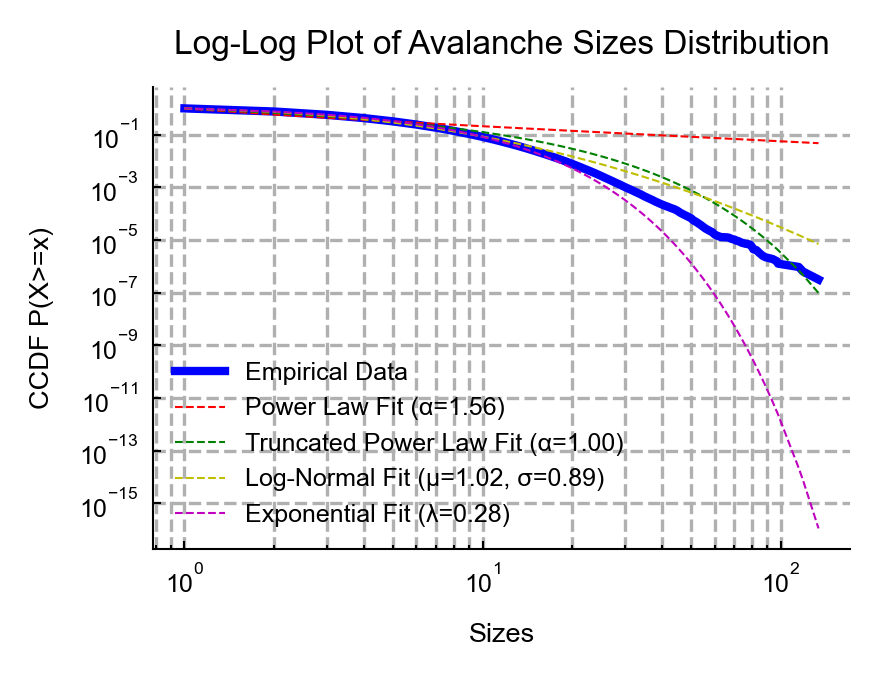


--- Avalanche Sizes Analysis ---
Exponent (alpha): 1.4910
Lower bound (x_min): 1.0
Loglikelihood Ratio (vs Log-Normal): -133.5106
p-value: 0.0000


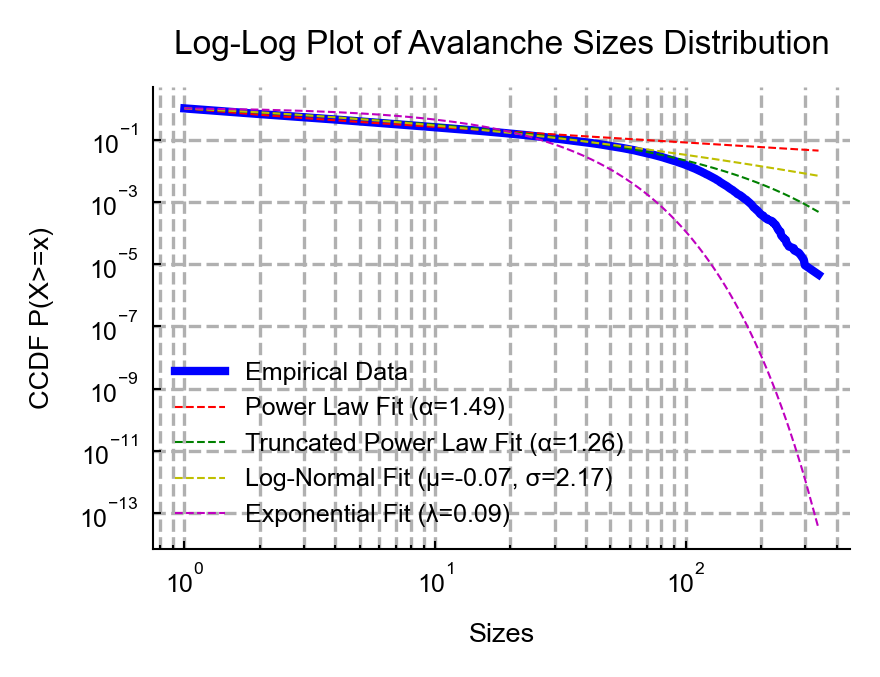

In [16]:
# refit with xmin = xmin
avalanche_fits_xmin = {}
for section in all_avalanche_sizes:
    avalanche_fits_xmin[section] = fit_power_law(all_avalanche_sizes[section], 'Avalanche Sizes', xmin=xmin)

In [75]:
for section in avalanche_data:
    print(avalanche_data[section]['size_fit_xmin'].distribution_compare('truncated_power_law', 'power_law', normalized_ratio=True))
    print(avalanche_data[section]['size_fit_xmin'].distribution_compare('truncated_power_law', 'exponential', normalized_ratio=True))
    print(avalanche_data[section]['size_fit_xmin'].distribution_compare('truncated_power_law', 'lognormal', normalized_ratio=True))

Assuming nested distributions
Assuming nested distributions


(0.5294437871783766, 0.32760663383487054)
(1.207834542782169, 0.2271109117049881)
(-0.04540514425221352, 0.9637843806979917)
(13.40686997435095, 0.0)
(3.1191125845827328, 0.0018139663477870463)
(4.48233691528645, 7.383006037747837e-06)


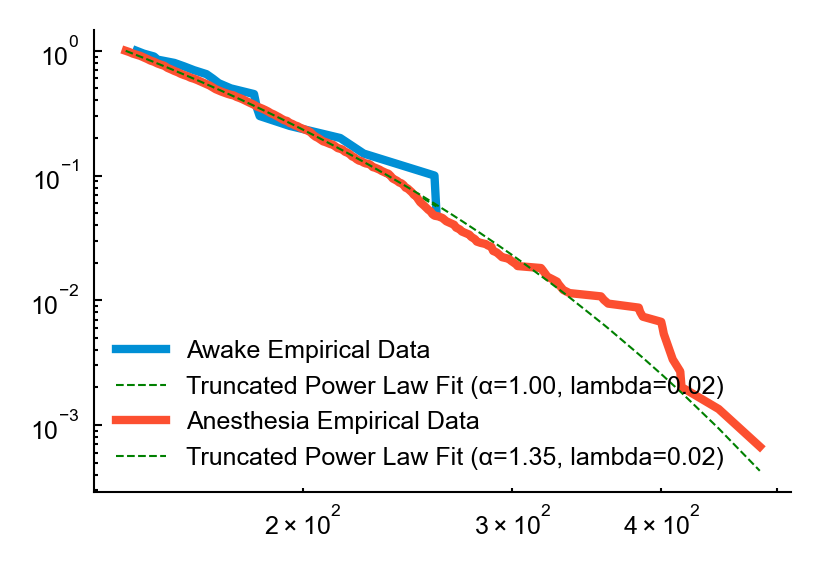

In [103]:
for section in avalanche_fits_xmin:
    fit = avalanche_fits_xmin[section]
    ax = plt.gca()
    fit.plot_ccdf(ax=ax, linewidth=2, label=f'{section} Empirical Data')
    fit.truncated_power_law.plot_ccdf(ax=ax, color='g', linestyle='--', label=f'Truncated Power Law Fit (α={fit.truncated_power_law.alpha:.2f}, lambda={fit.truncated_power_law.Lambda:.2f})')
plt.legend()
plt.show()

# LFP Avalanches

In [129]:
from scipy.signal import find_peaks
def find_lfp_avalanches(lfp_data, sampling_rate, threshold_sd=-3.0):
    """
    Computes neuronal avalanche sizes from a multi-channel LFP recording.

    This function follows the standard methodology from the literature:
    1. Detects negative LFP (nLFP) events based on a standard deviation threshold.
    2. Pools events from all channels.
    3. Defines the analysis time bin (Δt) as the average inter-event interval.
    4. Identifies avalanches as cascades of events separated by periods of silence.
    5. Calculates avalanche size as the sum of the absolute amplitudes of nLFP peaks.

    Args:
        lfp_data (np.ndarray): A T x N array of LFP signals, where T is the
                               number of time points and N is the number of channels.
        sampling_rate (int): The sampling rate of the LFP data in Hz.
        threshold_sd (float, optional): The standard deviation threshold for detecting
                                        nLFP events. Defaults to -3.0.

    Returns:
        np.ndarray: A 1D array containing the sizes of all detected avalanches.
                    Returns an empty array if no avalanches are found.
    """
    if not isinstance(lfp_data, np.ndarray) or lfp_data.ndim != 2:
        raise ValueError("lfp_data must be a 2D NumPy array (T x N).")

    n_samples, n_channels = lfp_data.shape
    all_events = []

    # --- Step 1 & 2: Detect nLFP Events on Each Channel ---
    print(f"Detecting events across {n_channels} channels...")
    for i in range(n_channels):
        channel_data = lfp_data[:, i]
        
        # Calculate the threshold for this channel
        mean_val = np.mean(channel_data)
        std_val = np.std(channel_data)
        threshold = mean_val + threshold_sd * std_val

        # We find negative peaks by inverting the signal and finding positive peaks
        # The 'height' parameter acts as our threshold.
        # We use the absolute value because the signal is inverted.
        peaks, properties = find_peaks(-channel_data, height=-threshold)
        
        # The magnitude is the absolute amplitude of the peak
        magnitudes = properties['peak_heights']
        
        for peak_idx, mag in zip(peaks, magnitudes):
            all_events.append({'time_index': peak_idx, 'magnitude': mag})

    if len(all_events) < 2:
        print("Fewer than 2 events detected. Cannot compute avalanches.")
        return np.array([])

    # --- Step 3: Pool Events and Determine Bin Size (Δt) ---
    # Sort events chronologically
    all_events.sort(key=lambda x: x['time_index'])
    
    event_times_sec = np.array([event['time_index'] for event in all_events]) / sampling_rate
    event_magnitudes = np.array([event['magnitude'] for event in all_events])

    # Calculate the average inter-event interval (IEI)
    inter_event_intervals = np.diff(event_times_sec)
    if len(inter_event_intervals) == 0:
        print("Not enough events to calculate inter-event interval.")
        return np.array([])

    delta_t = np.mean(inter_event_intervals)
    print(f"Calculated bin size (Δt) = {delta_t:.5f} seconds")

    # --- Step 4 & 5: Bin Events and Identify Avalanches ---
    total_duration_sec = n_samples / sampling_rate
    num_bins = int(np.ceil(total_duration_sec / delta_t))
    
    # Create a binned representation of events
    binned_events = [[] for _ in range(num_bins)]
    for time_sec, mag in zip(event_times_sec, event_magnitudes):
        bin_idx = int(time_sec / delta_t)
        if bin_idx < num_bins:
            binned_events[bin_idx].append(mag)

    avalanche_sizes = []
    current_avalanche_size = 0
    is_in_avalanche = False

    print("Identifying avalanches...")
    for bin_content in binned_events:
        if bin_content:  # If the bin is not empty
            is_in_avalanche = True
            current_avalanche_size += np.sum(bin_content)
        elif is_in_avalanche:  # The avalanche has just ended
            avalanche_sizes.append(current_avalanche_size)
            # Reset for the next avalanche
            is_in_avalanche = False
            current_avalanche_size = 0

    # Add the last avalanche if the recording ends during one
    if is_in_avalanche:
        avalanche_sizes.append(current_avalanche_size)

    print(f"Found {len(avalanche_sizes)} avalanches.")
    return avalanche_sizes

In [136]:
lfp_data = {}
lfp_times = np.arange(session_file['lfp'].shape[1])*0.001
for section in ['Awake', 'Anesthesia']:

    section_start, section_end = section_info[np.where([info[0] == section for info in section_info])[0][0]][1]
    section_start = section_start*60 + infusion_start
    section_end = section_end*60 + infusion_start
    lfp_segment = session_file['lfp'][:, (lfp_times > section_start) & (lfp_times < section_end)]
    # lfp_segment = session_file['lfp'][:, (lfp_times > section_start) & (lfp_times < section_start + 120)]
    lfp_data[section] = lfp_segment.T

In [137]:
avalanche_sizes = {}
for section in lfp_data:
    avalanche_sizes[section] = find_lfp_avalanches(lfp_data[section], 1000)

Detecting events across 250 channels...
Calculated bin size (Δt) = 0.00440 seconds
Identifying avalanches...
Found 5184 avalanches.
Detecting events across 250 channels...
Calculated bin size (Δt) = 0.00422 seconds
Identifying avalanches...
Found 16318 avalanches.


Calculating best minimal value for power law fit
xmin progress: 99%
--- Avalanche Sizes Analysis ---
Exponent (alpha): 1.6689
Lower bound (x_min): 0.23934971629821958
Loglikelihood Ratio (vs Log-Normal): -1.8890
p-value: 0.0589


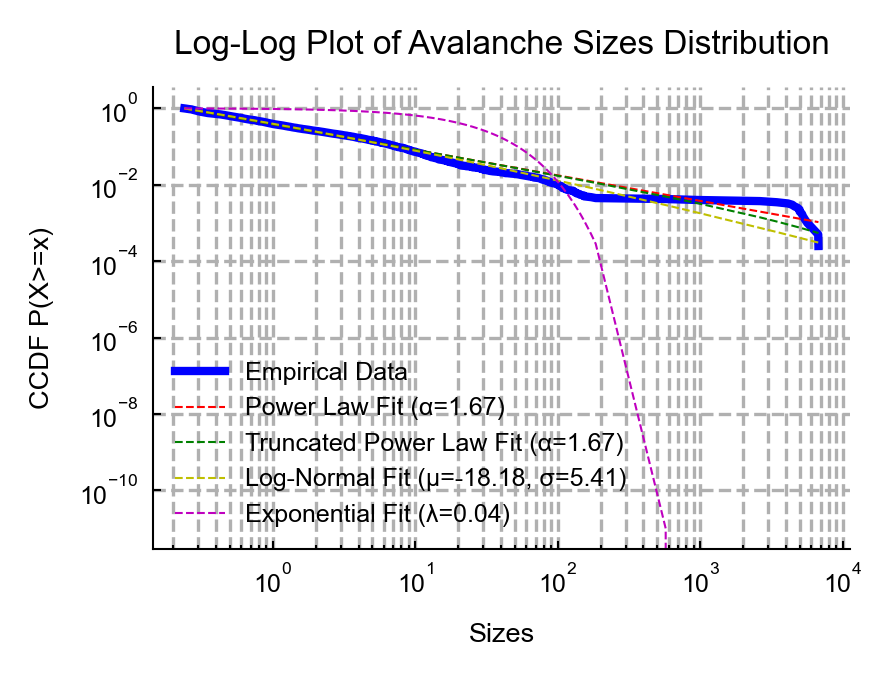

Calculating best minimal value for power law fit
xmin progress: 99%
--- Avalanche Sizes Analysis ---
Exponent (alpha): 3.8777
Lower bound (x_min): 259.24587890951415


/om2/user/eisenaj/miniforge3/envs/universal-unconsciousness/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Loglikelihood Ratio (vs Log-Normal): -1.3265
p-value: 0.1847


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


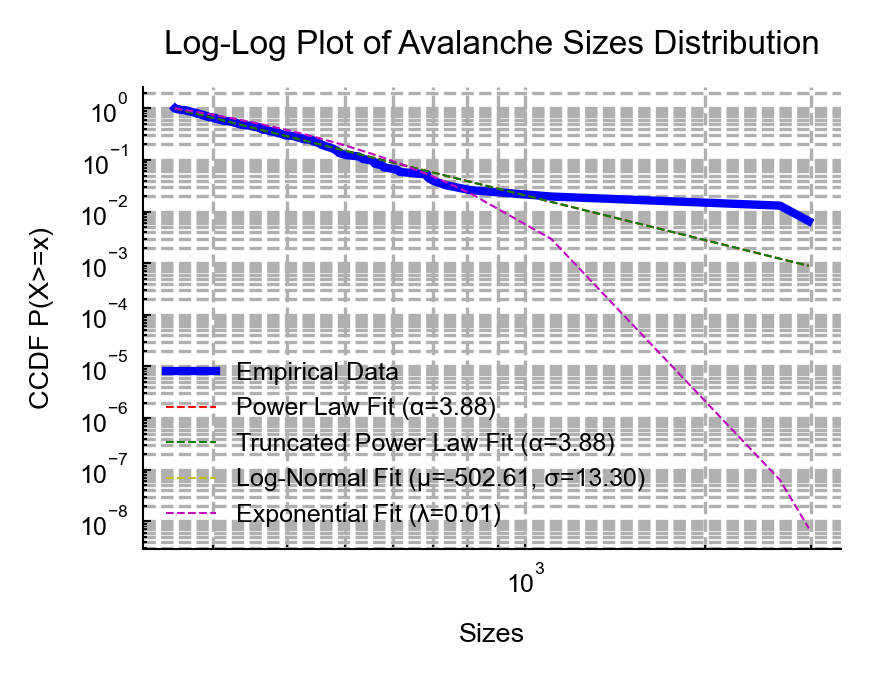

In [139]:
avalanche_fits = {}
for section in avalanche_sizes:
    avalanche_fits[section] = fit_power_law(avalanche_sizes[section], 'Avalanche Sizes', discrete=False)

# DFA

In [10]:
from fathon import DFA
import nolds

In [31]:
dfa_data = {}
for section in ['Awake', 'Anesthesia']:
    dfa_data[section] = {}
    for i in tqdm(range(session_file['spikeTimes'].shape[0])):
        section_start, section_end = section_info[np.where([info[0] == section for info in section_info])[0][0]][1]
        section_start = section_start*60 + infusion_start
        section_end = section_end*60 + infusion_start
    # raise Exception('Stop here')

  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

In [32]:
lfp_times = np.arange(session_file['lfp'].shape[1])*0.001

In [33]:
lfp_segment = session_file['lfp'][:, (lfp_times > section_start) & (lfp_times < section_start + 15)]

In [23]:
nolds.dfa(lfp_segment[-1])

1.1420987339798887

In [18]:
nolds.lyap_r(lfp_segment[0])

KeyboardInterrupt: 

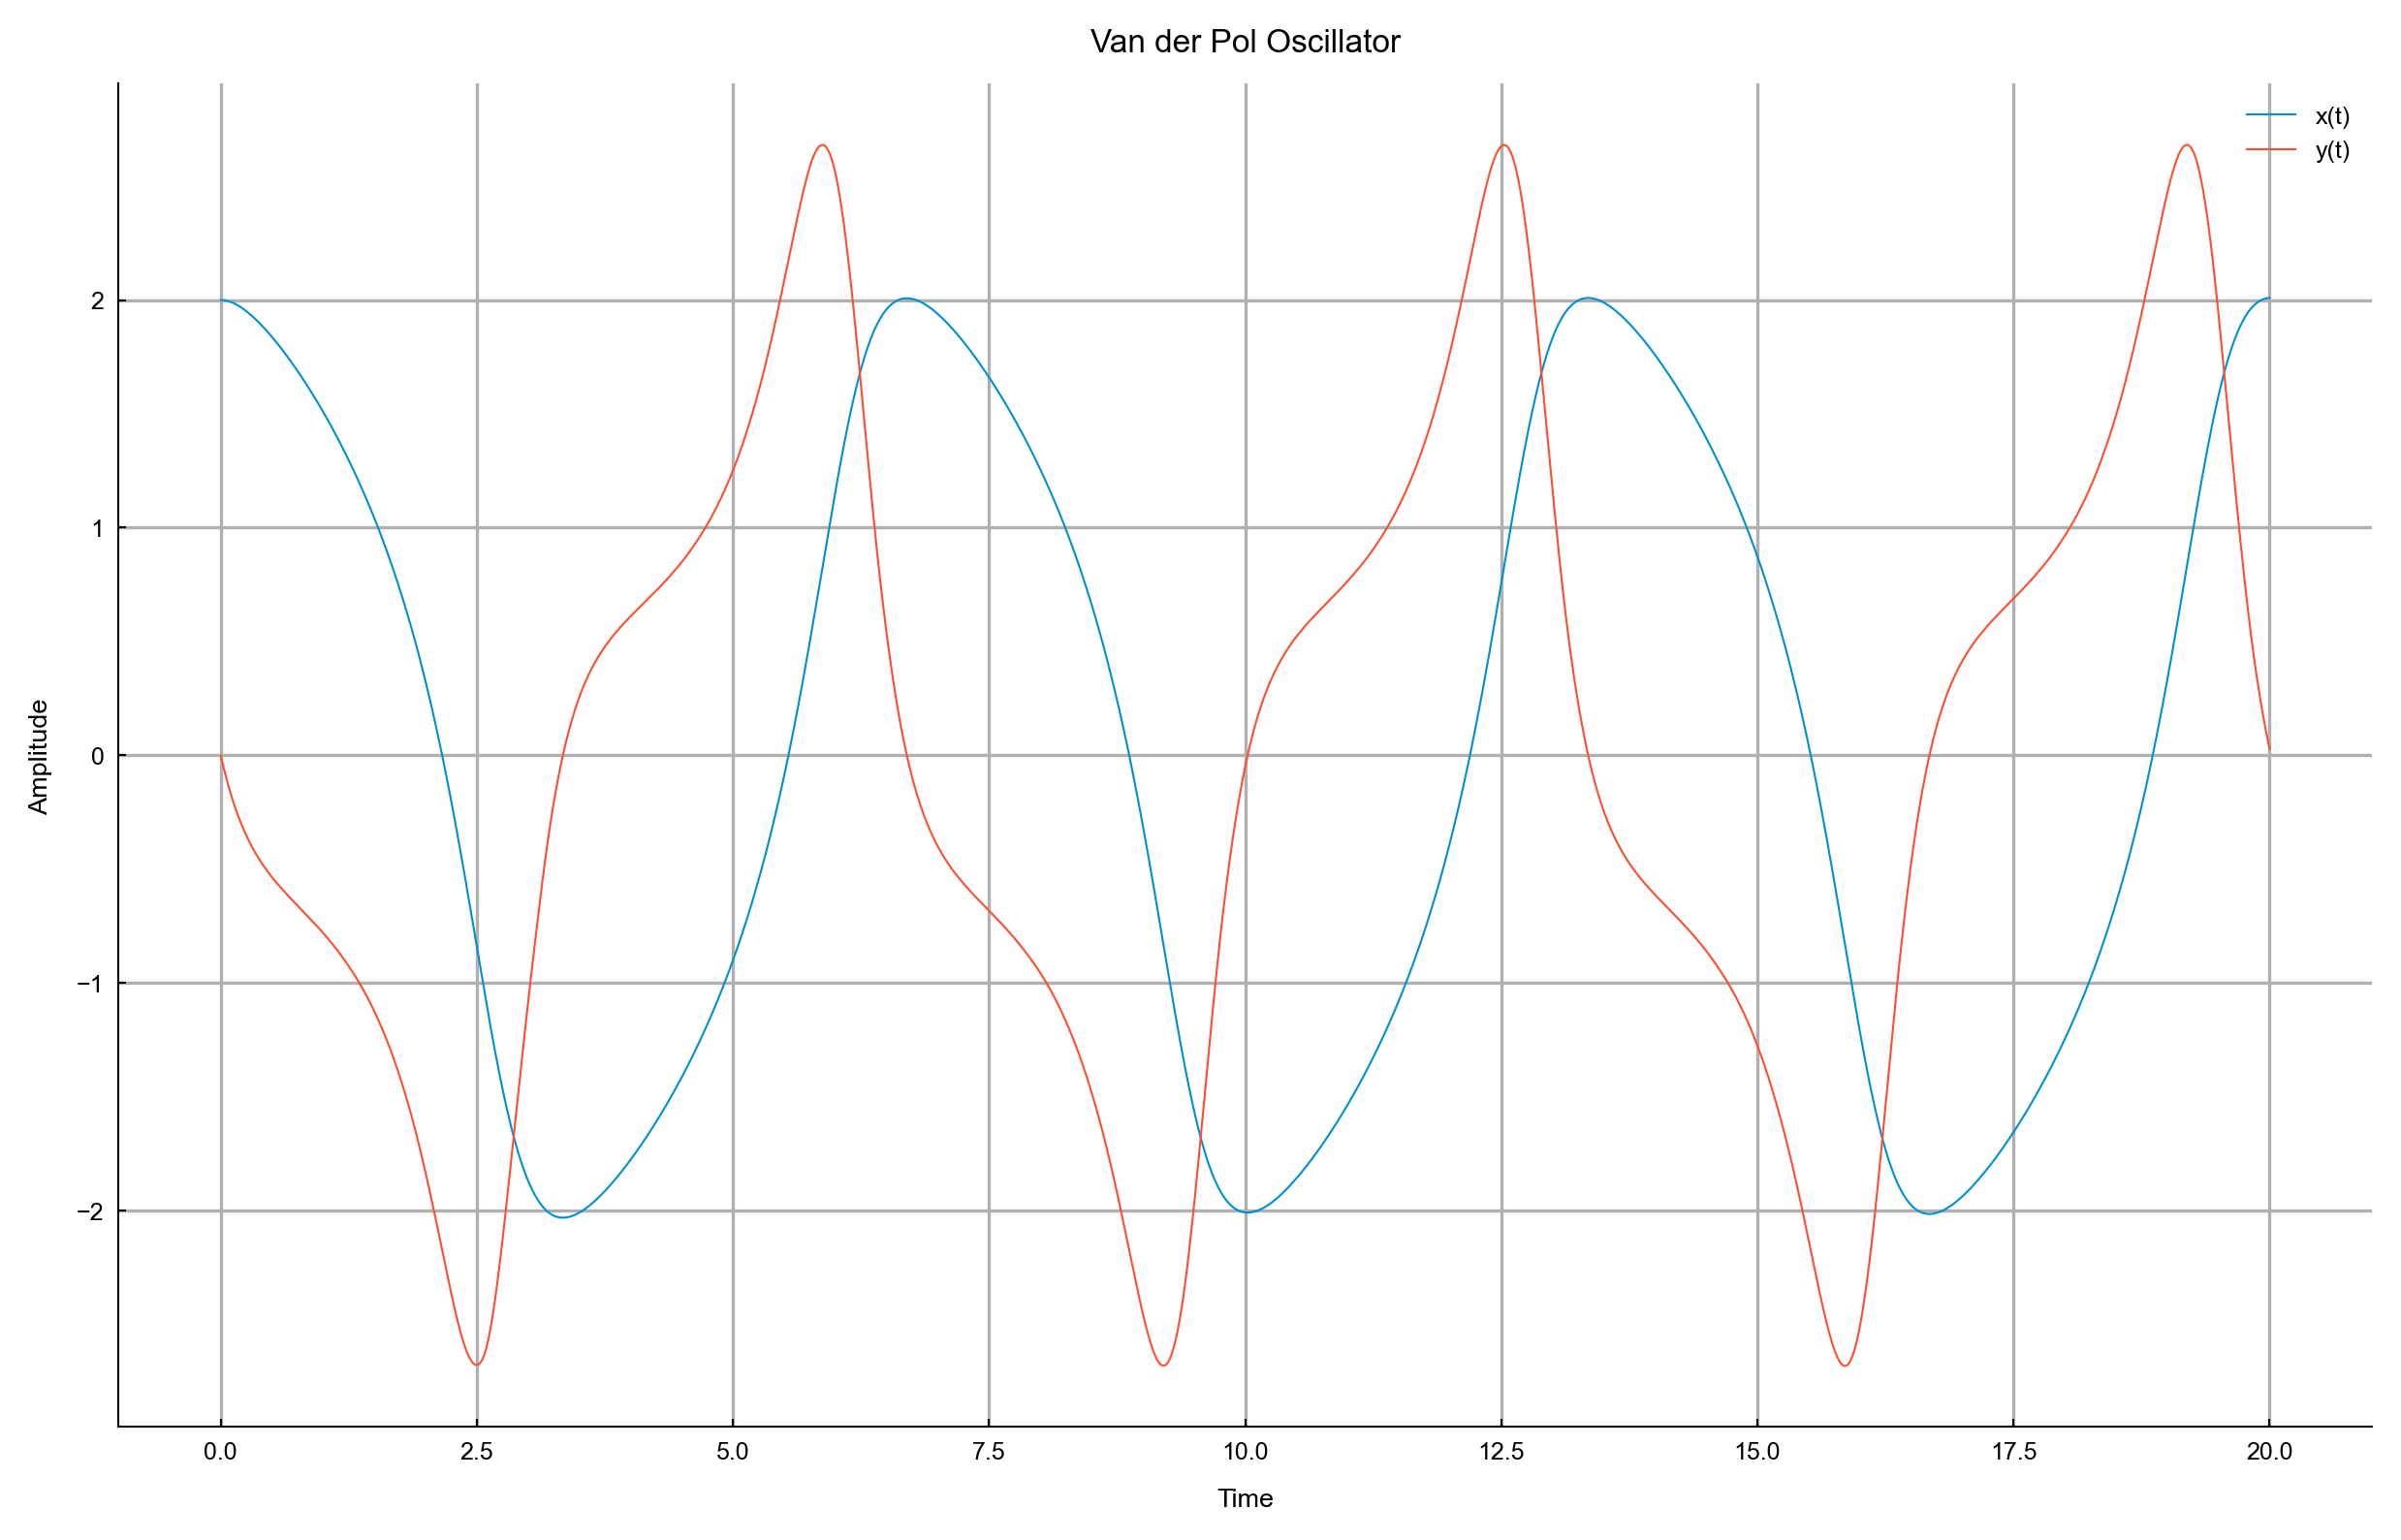

In [27]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the Van der Pol oscillator differential equation
def vanderpol(t, y, mu):
    dydt = [y[1], mu * (1 - y[0]**2) * y[1] - y[0]]
    return dydt

# Parameters
mu = 1.0  # The nonlinearity parameter
y0 = [2.0, 0.0]  # Initial conditions

# Time span
t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], 10000)

# Solve the differential equation
sol = solve_ivp(vanderpol, t_span, y0, args=(mu,), t_eval=t_eval)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='x(t)')
plt.plot(sol.t, sol.y[1], label='y(t)')
plt.title('Van der Pol Oscillator')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


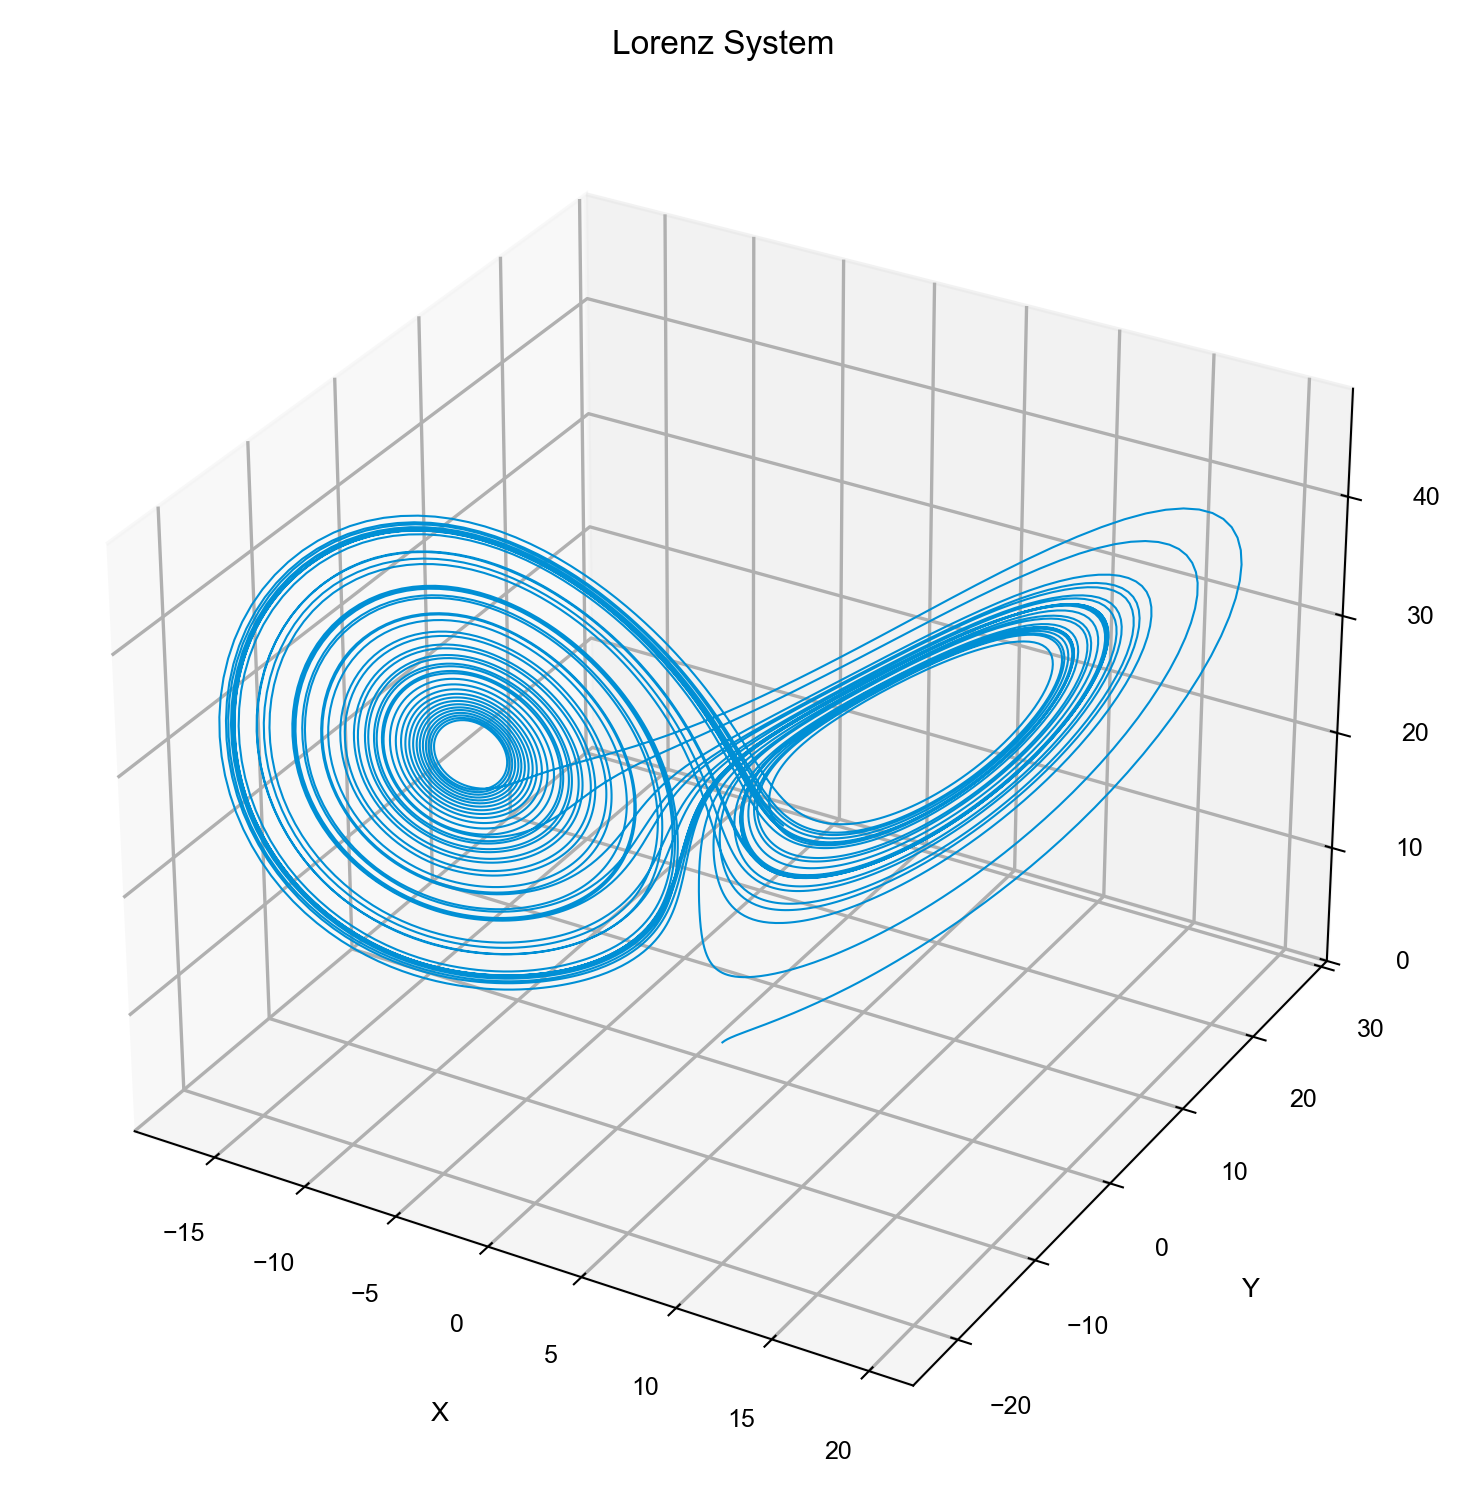

In [36]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the Lorenz system differential equations
def lorenz(t, state, sigma, beta, rho):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Parameters for the Lorenz system
sigma = 10.0
beta = 8.0 / 3.0
rho = 28.0

# Initial conditions
initial_state = [1.0, 1.0, 1.0]

# Time span
t_span = (0, 50)
t_eval = np.linspace(t_span[0], t_span[1], 10000)

# Solve the Lorenz system
sol = solve_ivp(lorenz, t_span, initial_state, args=(sigma, beta, rho), t_eval=t_eval)

# Plot the results
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(sol.y[0], sol.y[1], sol.y[2])
ax.set_title('Lorenz System')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


In [37]:
nolds.dfa(sol.y[0])

1.5726912777015236

In [39]:
nolds.dfa(sol.y[2])

1.353528097642566

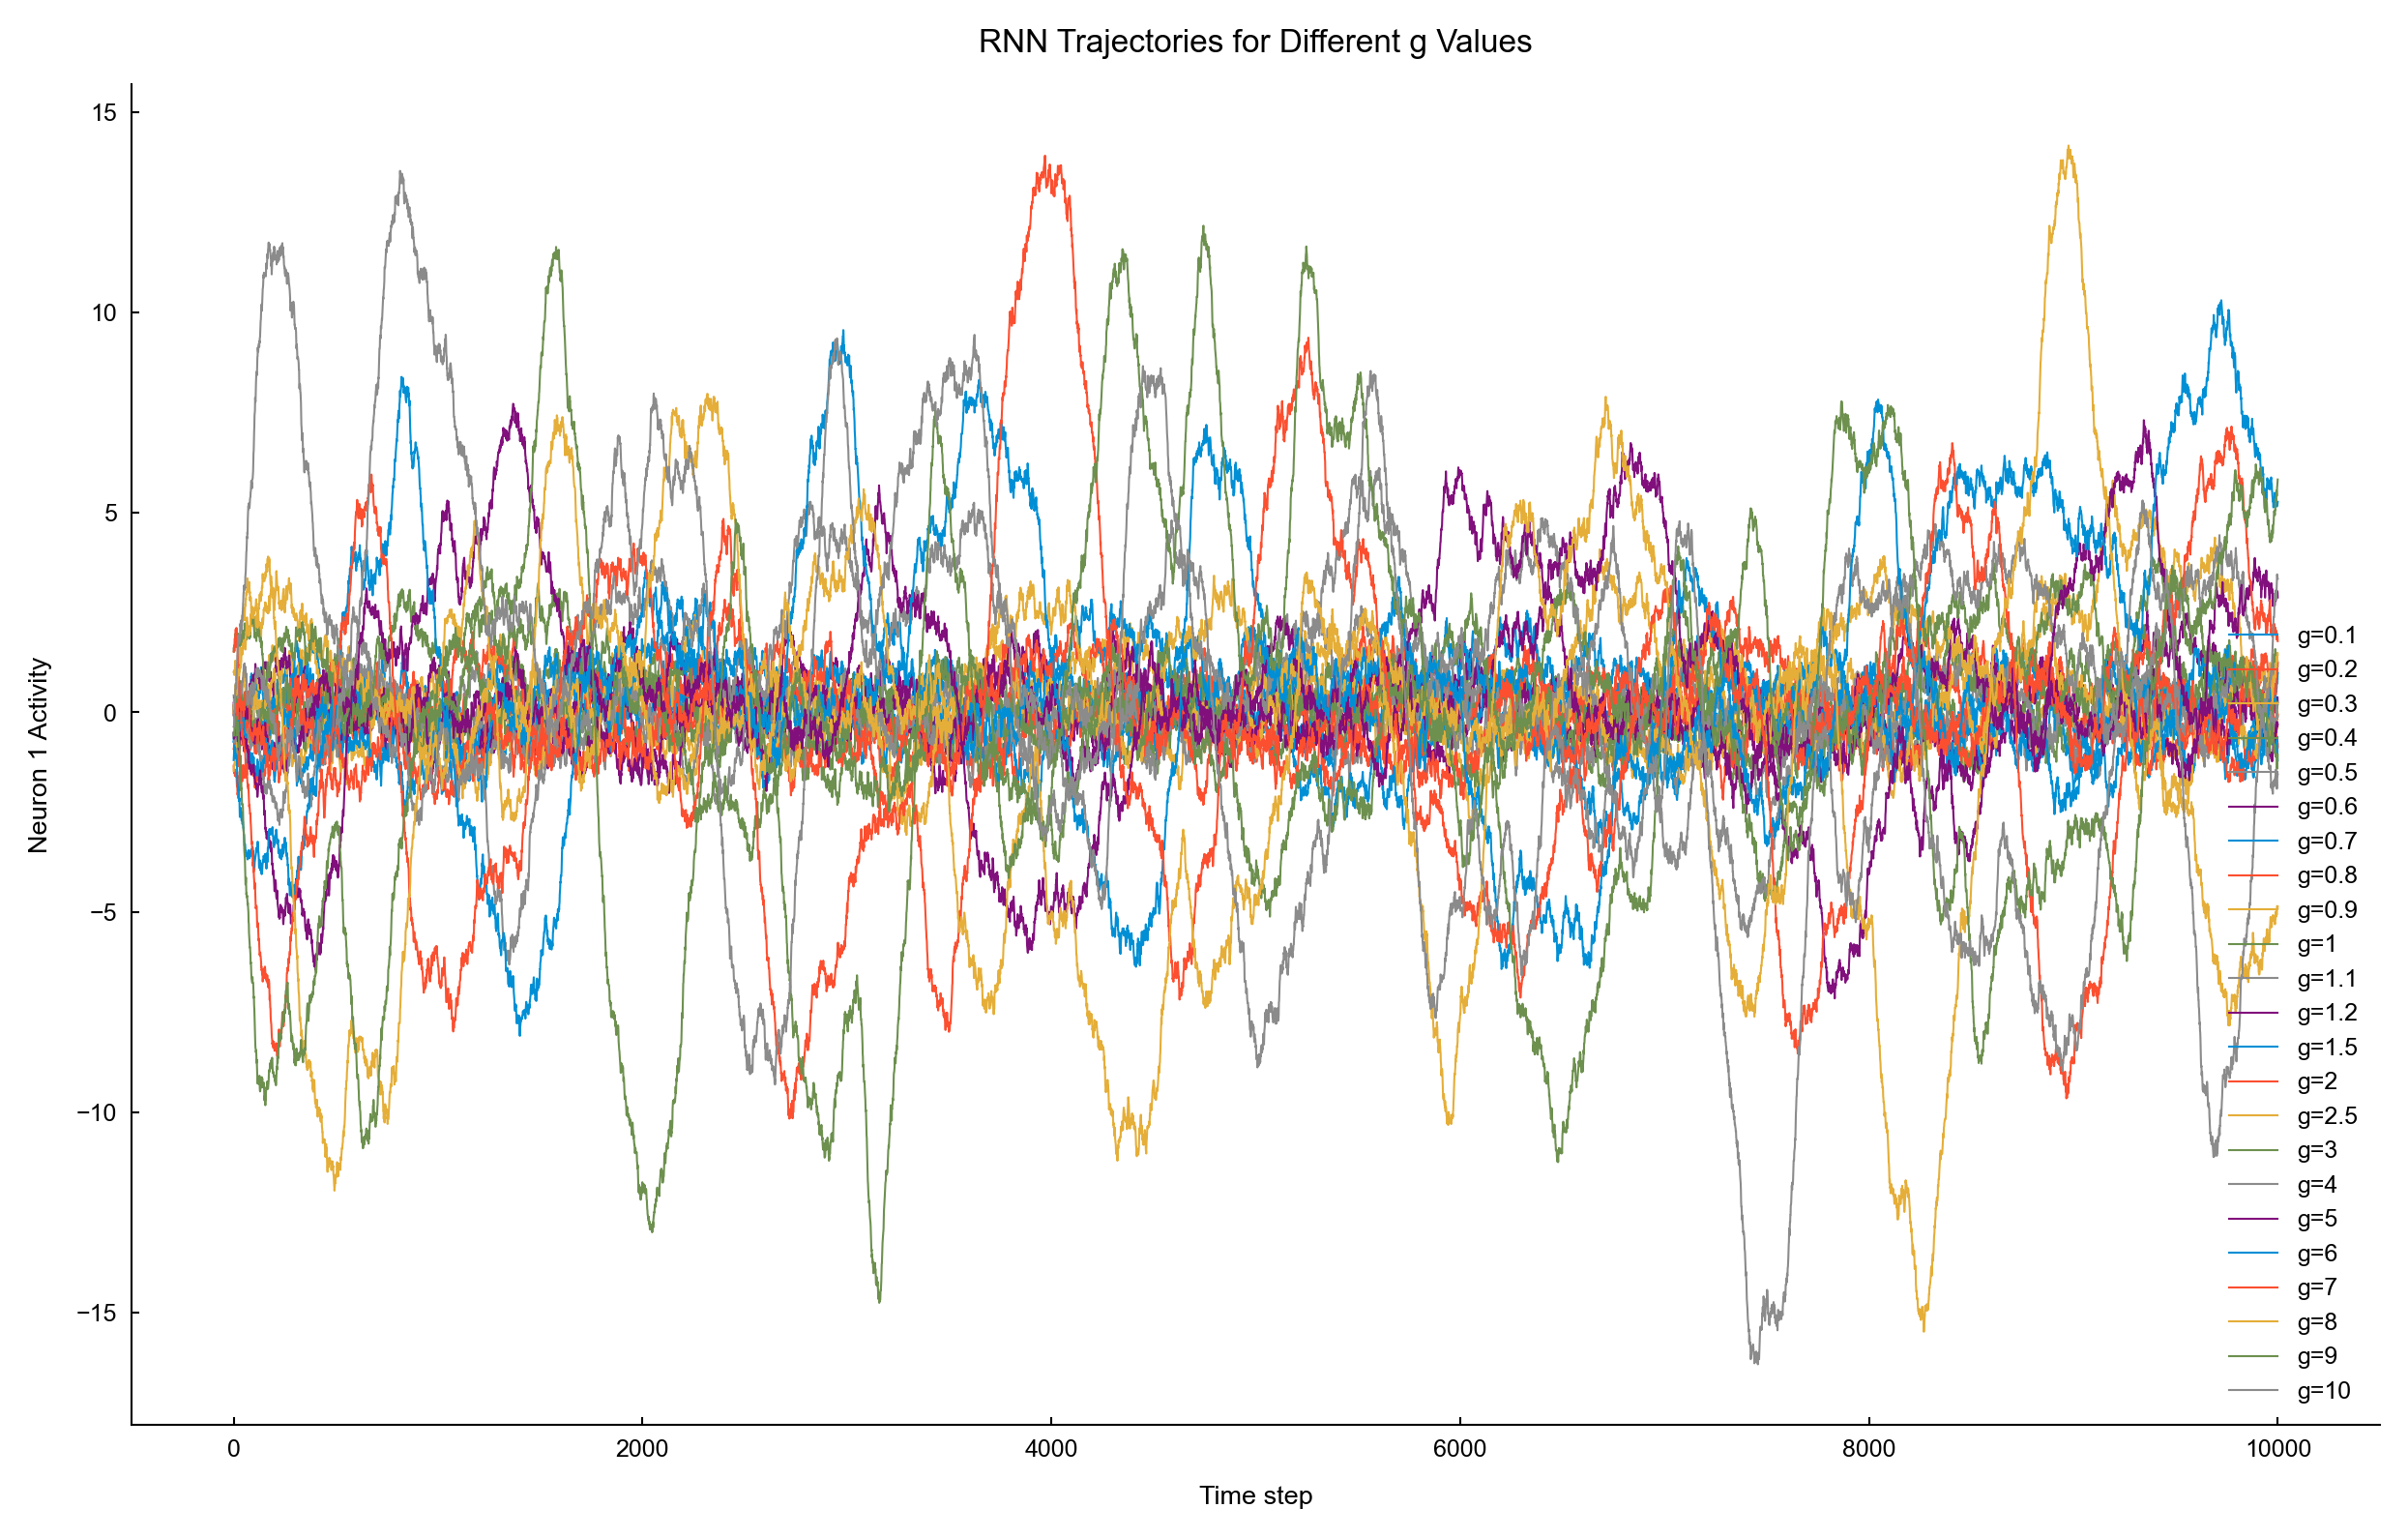

In [107]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
N = 128  # Number of neurons
dt = 0.01  # Time step
T = 10000  # Total time steps
noise_gain = 1  # Process noise gain
g_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10]  # Gain values

# Initialize the weight matrix with Gaussian distribution
W = np.random.randn(N, N) / np.sqrt(N)

# Function to simulate RNN using Euler-Maruyama method
def simulate_rnn(g):
    # Initialize state
    x = np.random.randn(N)
    # Store the trajectory
    trajectory = np.zeros((T, N))
    
    for t in range(T):
        # Compute the update using Euler-Maruyama
        dx = (-x + g * np.dot(W, np.tanh(x))) * dt + noise_gain * np.sqrt(dt) * np.random.randn(N)
        x += dx
        trajectory[t] = x
    
    return trajectory

# Simulate for each g value
trajectories = {g: simulate_rnn(g) for g in g_values}

# Example: Plot the trajectory of the first neuron for each g
fig, ax = plt.subplots(figsize=(10, 6))
for g in g_values:
    ax.plot(trajectories[g][:, 0], label=f'g={g}')
ax.set_title('RNN Trajectories for Different g Values')
ax.set_xlabel('Time step')
ax.set_ylabel('Neuron 1 Activity')
ax.legend()
plt.show()


In [108]:
alpha_vals = {}
for g in g_values:
    alpha_vals[g] = nolds.dfa(trajectories[g][:, 0])

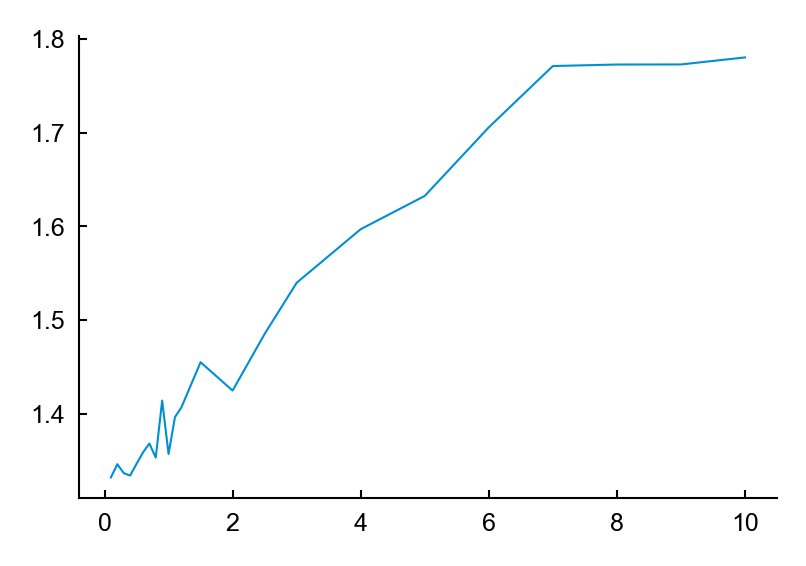

In [109]:
plt.plot(g_values, [alpha_vals[g] for g in g_values])
plt.show()


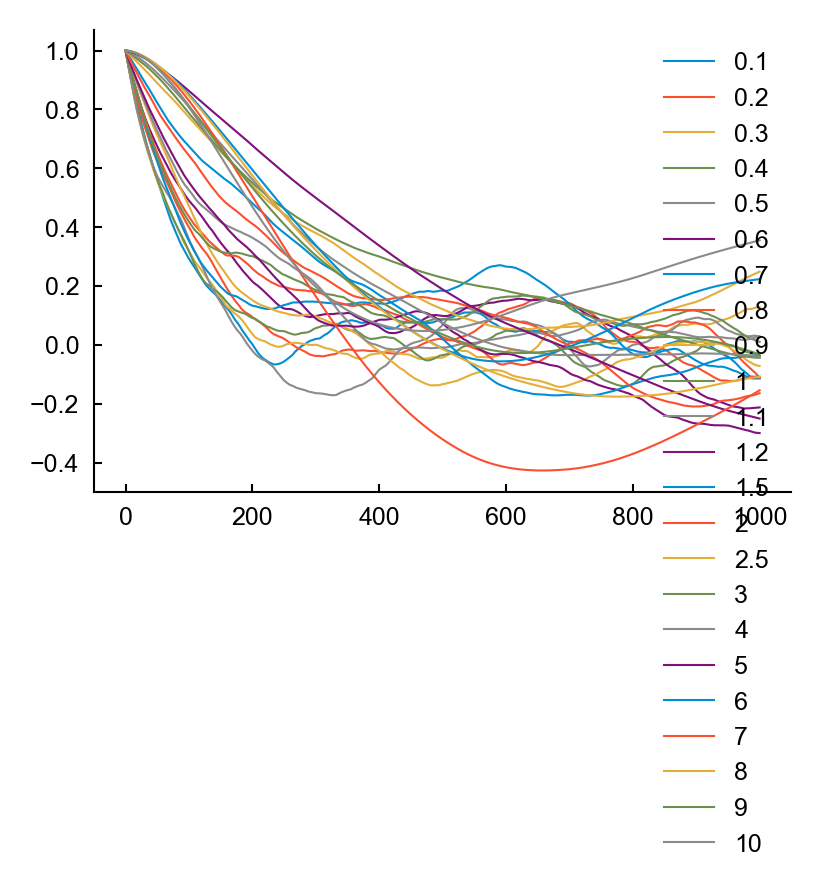

In [110]:
# compute the autocorelation of the trajectories
from statsmodels.tsa.stattools import acf
autocorrelation_func = {}
acf_50_crossing = {}
for g in g_values:
    autocorrelation_func[g] = acf(trajectories[g][:, 0], nlags=1000)
    # find the 0.5 crossing point
    acf_50_crossing[g] = np.where(autocorrelation_func[g] < 0.5)[0][0]

plt.plot(np.array([autocorrelation_func[g] for g in g_values]).T, label=g_values)
plt.legend()
plt.show()


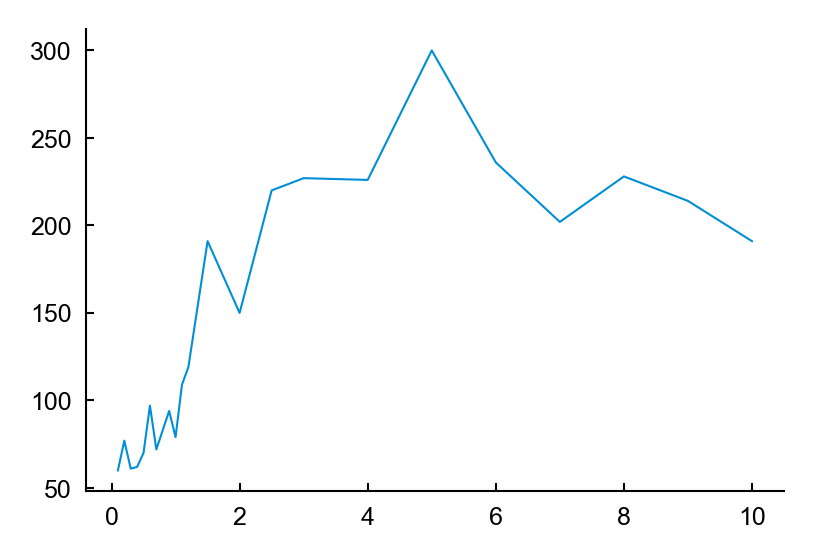

In [111]:
plt.plot(g_values, [acf_50_crossing[g] for g in g_values])

In [112]:
def compute_jacobian(x, g, W, dt):
    # Compute the Jacobian of the RNN update
    tanh_x = np.tanh(x)
    diag_tanh_derivative = np.zeros((x.shape[0], x.shape[1], x.shape[1]))
    for i in range(x.shape[0]):
        diag_tanh_derivative[i, :, :] = np.diag(1 - tanh_x[i, :]**2)
    jacobian = -np.eye(x.shape[-1]).reshape(1, x.shape[-1], x.shape[-1]) + g * W.reshape(1, x.shape[-1], x.shape[-1]) @ diag_tanh_derivative
    return np.eye(x.shape[-1]).reshape(1, x.shape[-1], x.shape[-1]) + jacobian * dt

jacobians = {}
lyaps = {}
for g in tqdm(g_values):
    jacobians[g] = compute_jacobian(trajectories[g], g, W, dt)
    lyaps[g] = compute_lyaps(torch.from_numpy(jacobians[g]), dt=0.01, k=1, verbose=False)

  0%|          | 0/23 [00:00<?, ?it/s]

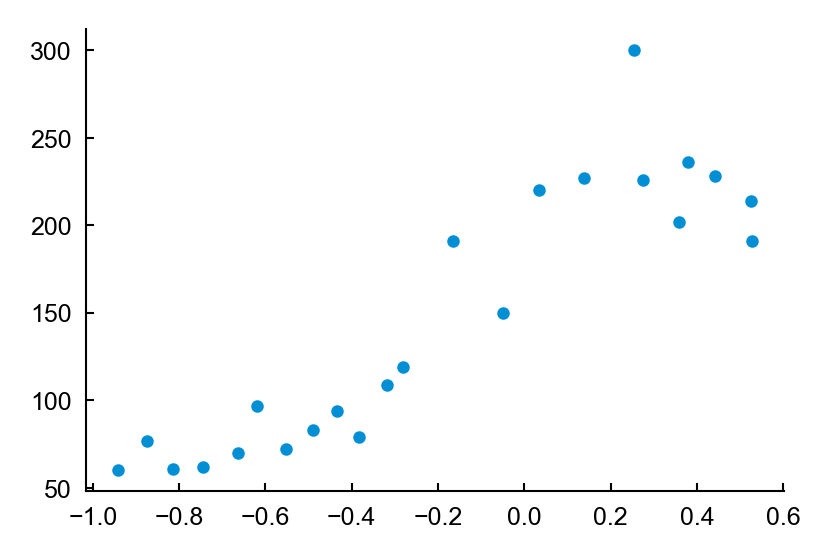

In [113]:
plt.scatter([lyaps[g][0] for g in g_values], [acf_50_crossing[g] for g in g_values])

In [82]:
def compute_lyaps(Js, dt=1, k=None, verbose=False):
    squeeze = False
    if len(Js.shape) == 3:
        Js = Js.unsqueeze(0)
        squeeze = True

    T, n, _ = Js.shape[-3], Js.shape[-2], Js.shape[-1]
    old_Q = torch.eye(n, device=Js.device, dtype=Js.dtype)
    
    if k is None:
        k = n

    old_Q = old_Q[:, :k]
    lexp = torch.zeros(*Js.shape[:-3], k, device=Js.device, dtype=Js.dtype)
    lexp_counts = torch.zeros(*Js.shape[:-3], k, device=Js.device, dtype=Js.dtype)

    for t in tqdm(range(T), disable=not verbose):
            
        # QR-decomposition of Js[t] * old_Q
        mat_Q, mat_R = torch.linalg.qr(torch.matmul(Js[..., t, :, :], old_Q))
        
        # force diagonal of R to be positive
        # sign_diag = torch.sign(torch.diag(mat_R))
        diag_R = mat_R.diagonal(dim1=-2, dim2=-1)
        sign_diag = torch.sign(diag_R)
        sign_diag[sign_diag == 0] = 1
        sign_diag = torch.diag_embed(sign_diag)
        
        mat_Q = mat_Q @ sign_diag
        mat_R = sign_diag @ mat_R
        old_Q = mat_Q
        
        # Successively build sum for Lyapunov exponents
        diag_R = mat_R.diagonal(dim1=-2, dim2=-1)

        # Filter zeros in mat_R (would lead to -infs)
        idx = diag_R > 0
        lexp_i = torch.zeros_like(diag_R, dtype=Js.dtype, device=Js.device)
        lexp_i[idx] = torch.log(diag_R[idx])
        lexp[idx] += lexp_i[idx]
        lexp_counts[idx] += 1
    if squeeze:
        lexp = lexp.squeeze(0)
        lexp_counts = lexp_counts.squeeze(0)
    
    return torch.flip(torch.sort((lexp / lexp_counts) * (1 / dt), axis=-1)[0], dims=[-1])

  0%|          | 0/10000 [00:00<?, ?it/s]

tensor([-453.3740, -453.6979, -453.8293, -454.0890, -454.3455, -454.5545,
        -454.6415, -454.9471, -455.0141, -455.1873, -455.3748, -455.5329,
        -455.6220, -455.6936, -455.8327, -455.9135, -456.0344, -456.1270,
        -456.2691, -456.3545, -456.4506, -456.5562, -456.7130, -456.7405,
        -456.8776, -456.9631, -457.0925, -457.1851, -457.3252, -457.4046,
        -457.4141, -457.5269, -457.6527, -457.7633, -457.8629, -457.9861,
        -458.0417, -458.2079, -458.3405, -458.4468, -458.4998, -458.5721,
        -458.7058, -458.7908, -458.9201, -459.0791, -459.1131, -459.2111,
        -459.2713, -459.3790, -459.5412, -459.5709, -459.6874, -459.7706,
        -459.8347, -459.9319, -459.9654, -460.0664, -460.1215, -460.2260,
        -460.2493, -460.3584, -460.3614, -460.4271, -460.4873, -460.5206,
        -460.5797, -460.6624, -460.7583, -460.8379, -460.9900, -461.0416,
        -461.1552, -461.2279, -461.2936, -461.4288, -461.5460, -461.6954,
        -461.7207, -461.8067, -461.916

In [98]:
jacobians[g].shape

(10000, 128, 128)

In [ ]:
# Save a sanitized copy without powerlaw.Fit objects
out_path = save_avalanche_analysis_data(avalanche_analysis_data, avalanche_data_dir)
print(f"Pickle saved to: {out_path}")

# Optional quick load-check
_ = pd.read_pickle(out_path)
print("Reloaded sanitized pickle successfully.")
